In [1]:
import numpy as np
import h5py

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils
import emulator
from chain_variables import *

In [2]:
color_glam = 'magenta'
color_aemulus = 'blue'
color_emuperf = 'green'

In [3]:
L_glam = 1000.
L_aemulus = 1050.

In [4]:
def covfn_from_chaintag(chaintag):
    chain_fn = f'../chains/chains_{chaintag}.h5'
    cov_dir = '../../clust/covariances/'
    with h5py.File(chain_fn, 'r+') as f:

        statistics = f.attrs['statistic']
        traintags = f.attrs['traintag']
        testtags = f.attrs['testtag']
        errtags = f.attrs['errtag']
        stat_str = '_'.join(statistics)
        tags = f.attrs['tag']
        nstats = len(statistics)
        acctags = [None]*nstats
        for i, statistic in enumerate(statistics):
            gptag = traintags[i] + errtags[i] + tags[i]
            acctags[i] = gptag + testtags[i]

        # If all tags the same, the tag string will just be that string
        if len(set(traintags))==1 and len(set(errtags))==1 and len(set(testtags))==1:
            tag_str = traintags[0] + errtags[0] + testtags[0]
        else:
            # Otherwise will need to join them all
            print("Using acctags joined for emu")
            tag_str.join(acctags)
            
        cov_emuperf_fn = f"{cov_dir}cov_emuperf_{stat_str}{tag_str}.dat"
        
    return cov_emuperf_fn

In [5]:
def get_cov(statistics, cov_tag, tag_str='', cov_dir='/home/users/ksf293/clust/covariances'):
    stat_str = '_'.join(statistics)
    cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{tag_str}.dat"
    cov = np.loadtxt(cov_fn)
    return cov

In [35]:
def plot_correlation_matrix(corr, statistics):
    
    nstats = len(statistics)
    plt.figure(figsize=(2.5*nstats,2.5*nstats))
    tick_labels = np.concatenate([np.round(r_dict[stat], 2) for stat in statistics])
    im = plt.imshow(corr, origin='lower left', cmap='bwr_r', vmin=-1, vmax=1)
    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)
    plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)

    # Label statistics
    for i, statistic in enumerate(statistics):
        plt.text(9*i+3.5, -6, statistic, fontsize=20)
        plt.text(-6, 9*i+3.5, statistic, fontsize=20, rotation=90)
        if i==0:
            continue
        plt.axvline(9*i-0.5, color='k')
        plt.axhline(9*i-0.5, color='k')

    plt.xlabel(r"r ($h^{-1}$Mpc)", labelpad=40)
    plt.ylabel(r"r ($h^{-1}$Mpc)", labelpad=40)

    plt.colorbar(im, fraction=0.046, pad=0.04)

In [36]:
def plot_icov_matrix(icov, statistics):
    
    nstats = len(statistics)
    plt.figure(figsize=(2.5*nstats,2.5*nstats))
    tick_labels = np.concatenate([np.round(r_dict[stat], 2) for stat in statistics])
    
    #absmax = np.max([np.max(icov), -np.min(icov)])
    #im = plt.imshow(icov, origin='lower left', cmap='bwr_r'), vmin=-absmax, vmax=absmax)
    
    orig_cmap = matplotlib.cm.bwr_r
    datarange = np.max(icov) - np.min(icov)
    zeropoint = np.abs(np.min(icov))/datarange
    shifted_cmap = shiftedColorMap(orig_cmap, midpoint=zeropoint, name='shifted')
    im = plt.imshow(icov, origin='lower left', cmap=shifted_cmap)

    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)
    plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)

    # Label statistics
    for i, statistic in enumerate(statistics):
        plt.text(9*i+3.5, -6, statistic, fontsize=20)
        plt.text(-6, 9*i+3.5, statistic, fontsize=20, rotation=90)
        if i==0:
            continue
        plt.axvline(9*i-0.5, color='k')
        plt.axhline(9*i-0.5, color='k')

    plt.xlabel(r"r ($h^{-1}$Mpc)", labelpad=40)
    plt.ylabel(r"r ($h^{-1}$Mpc)", labelpad=40)

    plt.colorbar(im, fraction=0.046, pad=0.04)

In [37]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [38]:
def plot_diagonal_covariance(statistics, covs, colors, labels, nbins=9, plot_stdev=False, show_legend=True):

    for i, cov in enumerate(covs):
        csize = nbins*len(statistics)
        assert (cov.shape[0]==csize) & (cov.shape[1]==csize), f'Covariance matrix {i} is wrong shape!'
    
    for s, statistic in enumerate(statistics):
        plt.figure(figsize=(8,6))
        ax = plt.gca()
        start = s*nbins
        end = (s+1)*nbins
        for i, cov in enumerate(covs):
            var = np.diag(cov)[start:end]
            ls = '-'
            if '{perf' in labels[i].split(' ')[0]:
                ls = '--'
            elif '{emu' in labels[i].split(' ')[0]:
                ls = ':'
                
            if plot_stdev:
                ax.plot(r_dict[statistic], np.sqrt(var), color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"standard deviation $\sigma$")
            else:
                ax.plot(r_dict[statistic], var, color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"variance $\sigma^2$")

        ax.set_title(statistic)
        ax.set_xlabel(r"r ($h^{-1}$Mpc)")
        ax.set_xscale(scale_dict[statistic][0])
        ax.set_yscale(scale_dict[statistic][1])
        if show_legend:
            ax.legend()

In [39]:
statistics_all = ['wp', 'xi', 'upf', 'mcf']

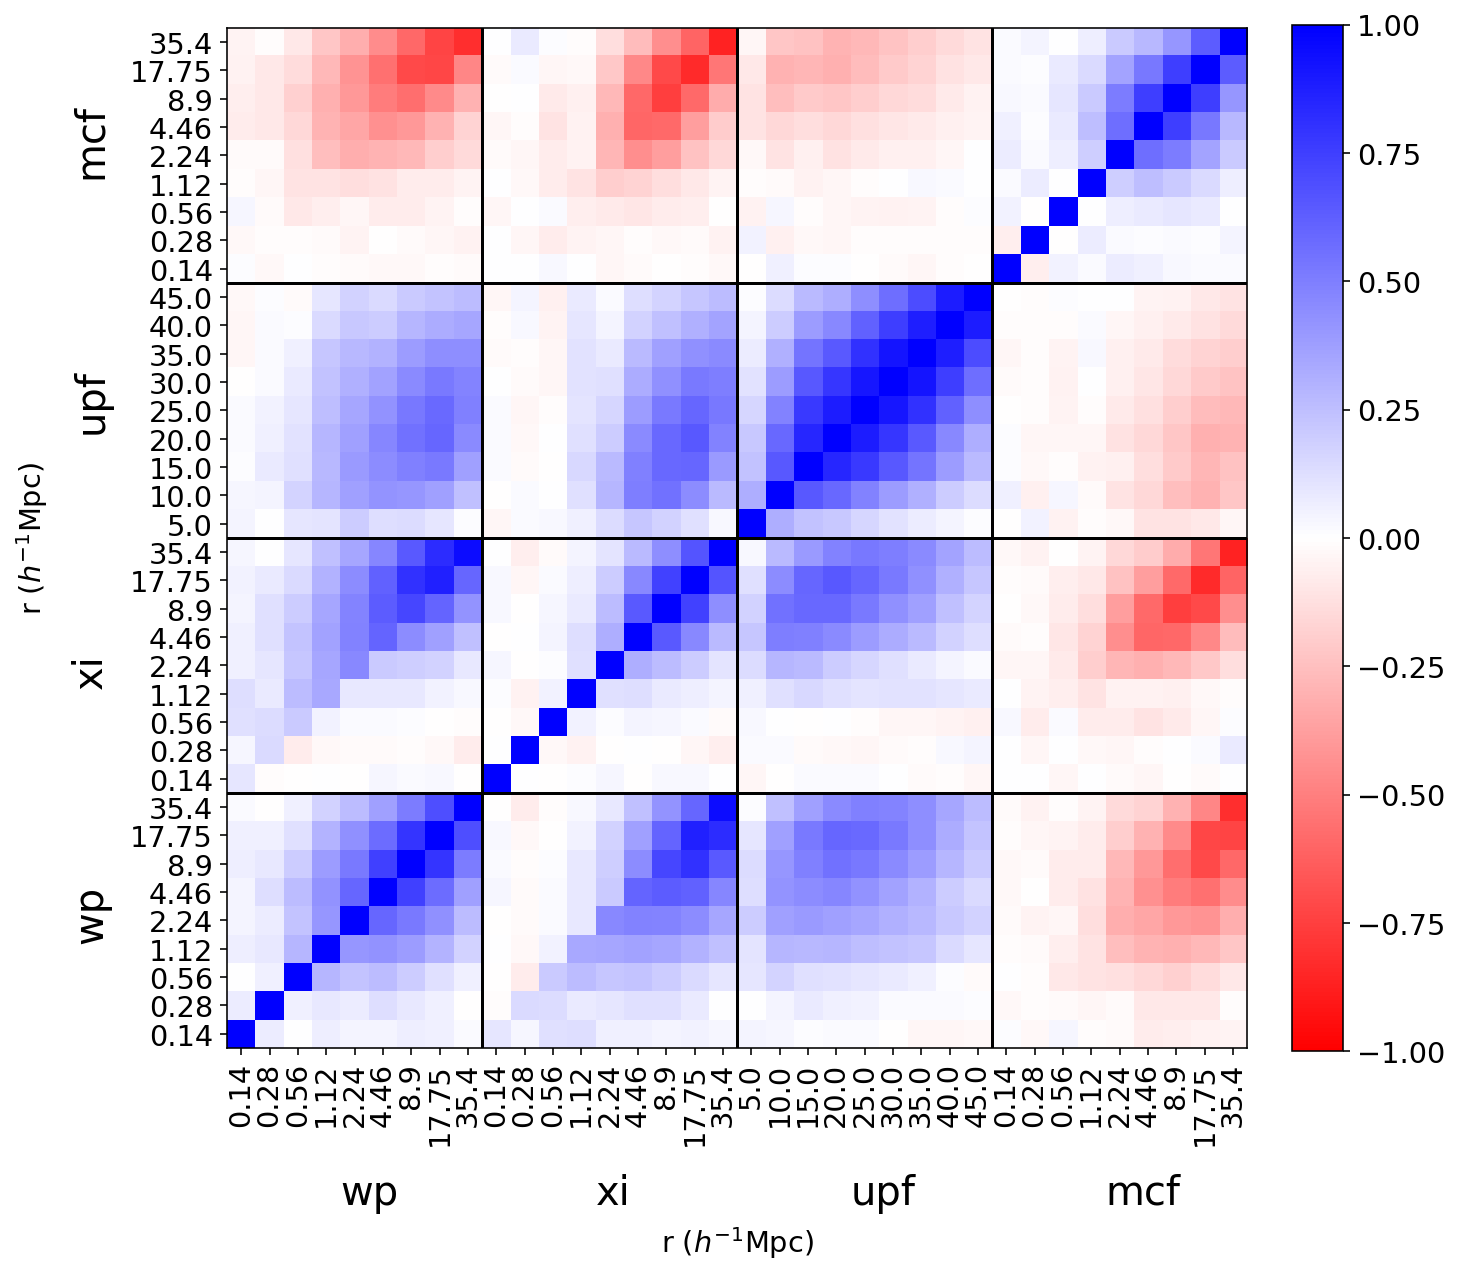

In [12]:
cov_glam = get_cov(statistics_all, 'glam')
corr_glam = utils.reduced_covariance(cov_glam)
plot_correlation_matrix(corr_glam, statistics_all)

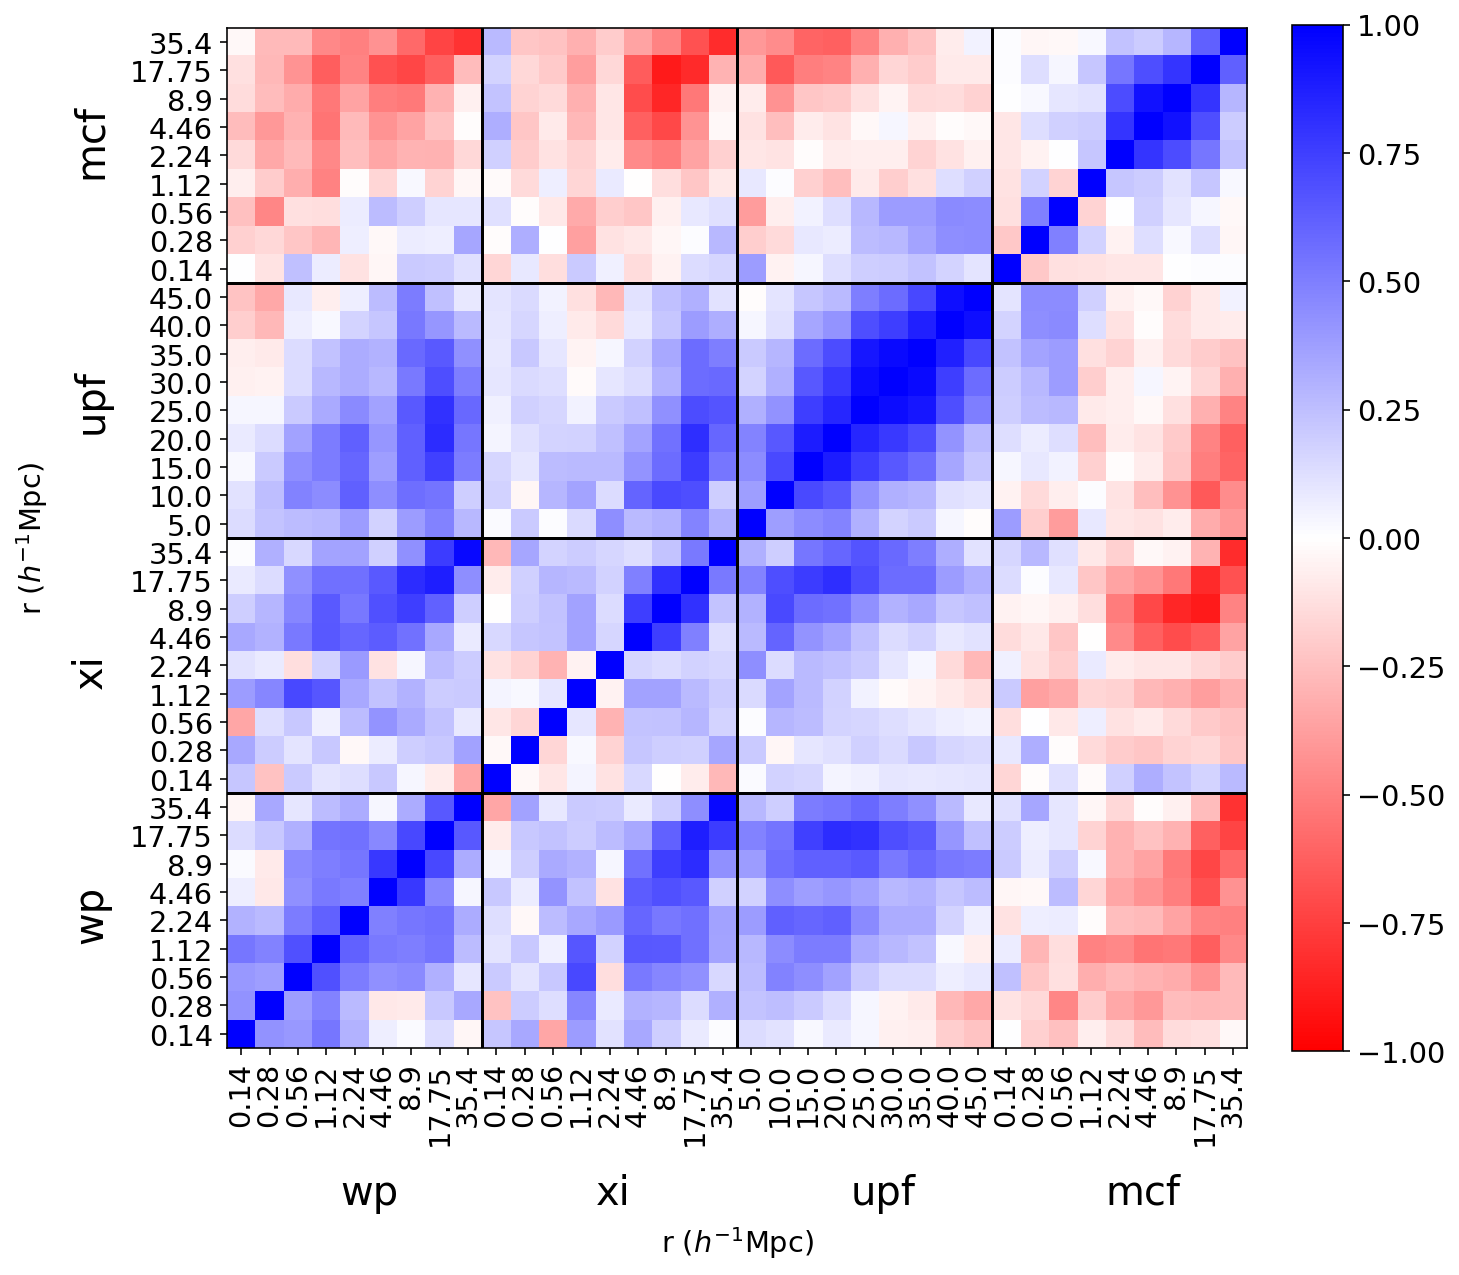

In [13]:
cov_aemulus = get_cov(statistics_all, 'aemulus', tag_str='_hod3_test0')
corr_aemulus = utils.reduced_covariance(cov_aemulus)
plot_correlation_matrix(corr_aemulus, statistics_all)

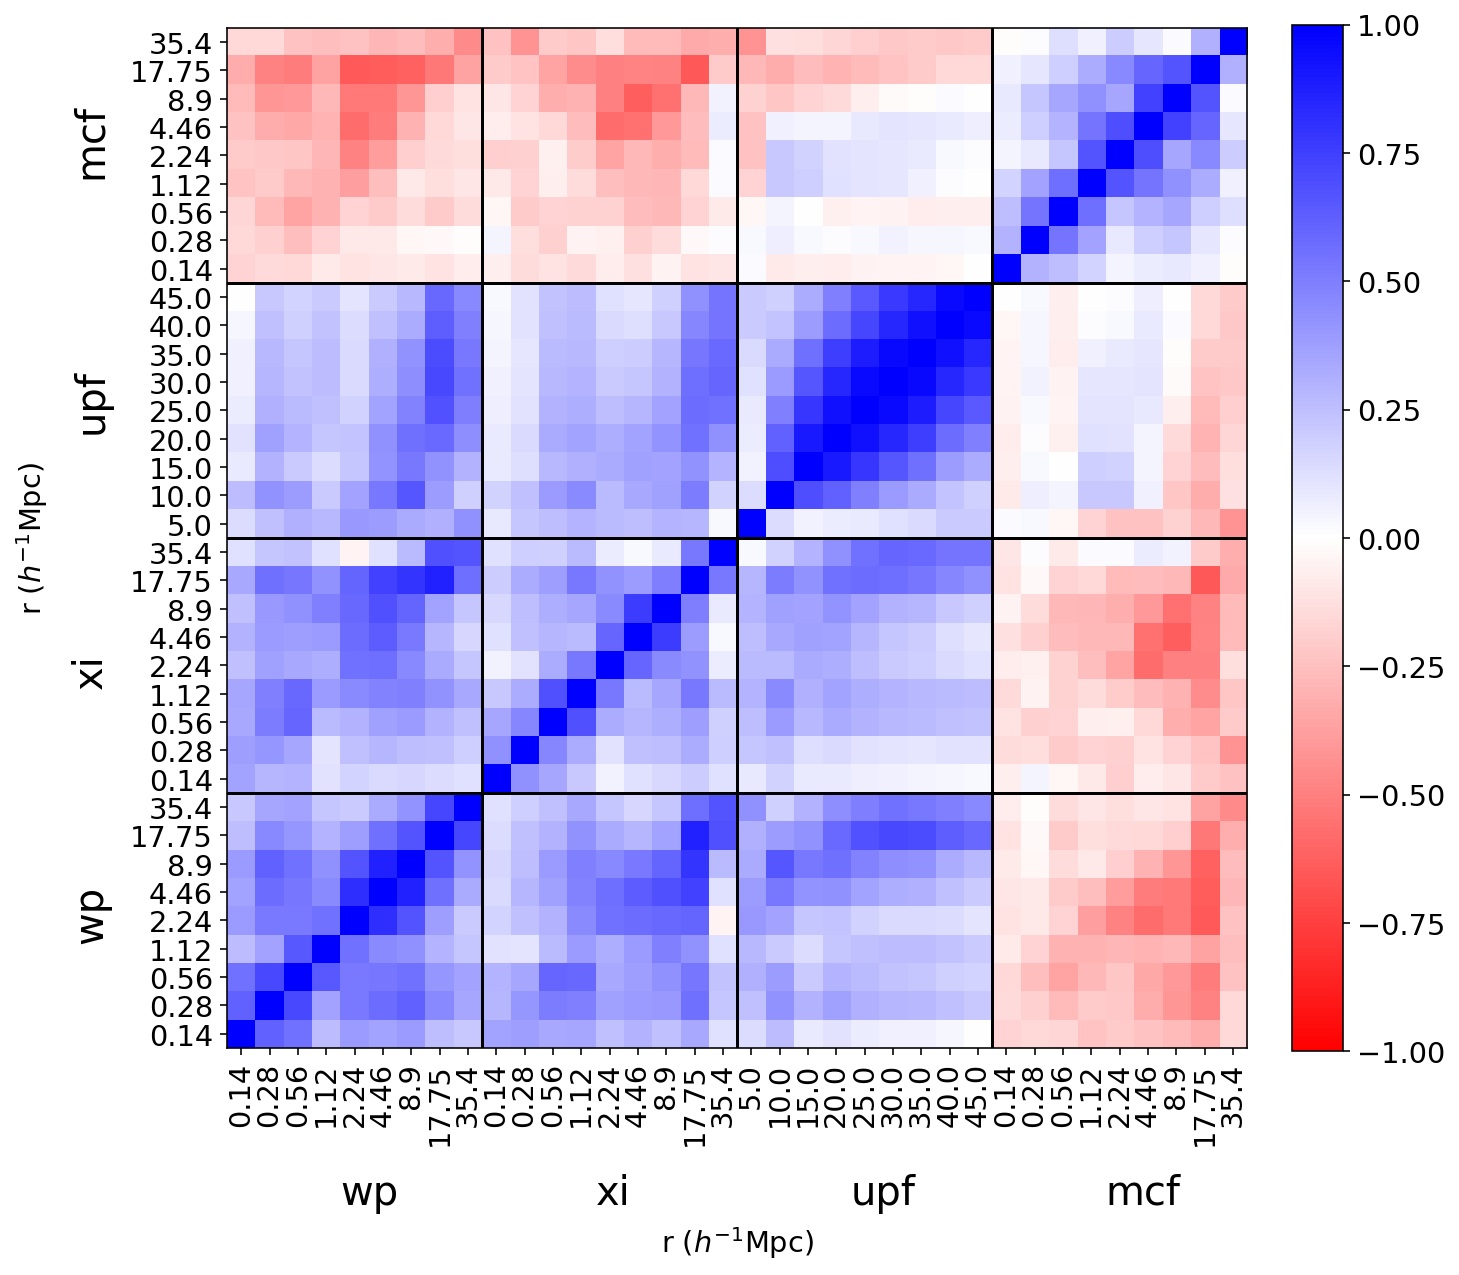

In [14]:
cov_emuperf = get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
corr_emuperf = utils.reduced_covariance(cov_emuperf)
plot_correlation_matrix(corr_emuperf, statistics_all)

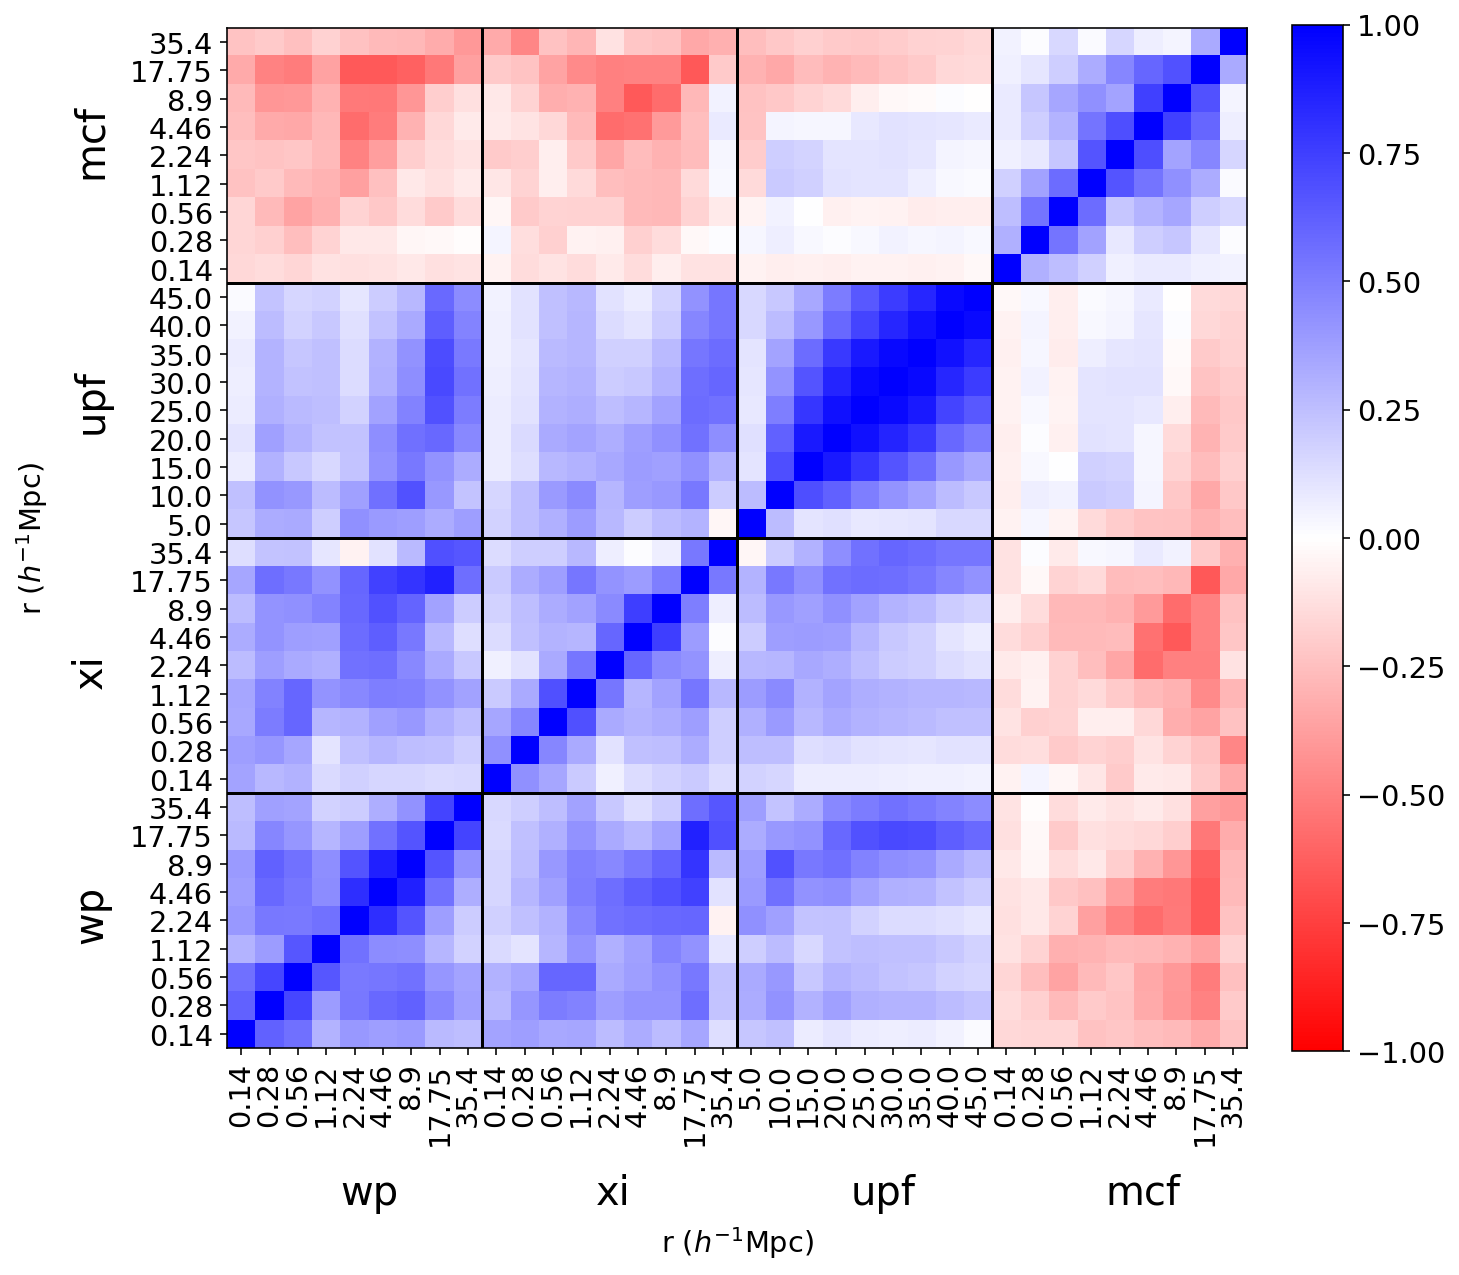

In [34]:
cov_emuperf_nonzeromean = get_cov(statistics_all, 'emuperf_nonzeromean', tag_str='_nonolap_hod3_test0_mean_test0')
corr_emuperf_nonzeromean = utils.reduced_covariance(cov_emuperf_nonzeromean)
plot_correlation_matrix(corr_emuperf_nonzeromean, statistics_all)

In [38]:
print(np.diag(cov_emuperf))
print(np.diag(cov_emuperf_nonzeromean))

[2.00044641e-04 3.06230052e-04 4.80487842e-04 3.86708689e-04
 5.56951908e-04 2.60362532e-04 3.24607653e-04 7.01125244e-04
 2.93262067e-03 2.92186735e-03 1.45139614e-03 8.63838345e-04
 5.69433994e-04 2.77679409e-04 2.25154156e-04 2.26169127e-04
 4.62260087e-04 5.02585486e-03 2.51192732e-06 8.73856042e-06
 3.22892496e-05 9.61381047e-05 3.84796366e-04 1.12256313e-03
 2.73951590e-03 1.08797756e-02 2.63300502e-02 3.73122227e-04
 1.32514982e-04 1.54540838e-04 1.34738804e-04 1.82356866e-04
 1.06996010e-04 6.93243995e-05 1.45753567e-05 6.60216097e-06]
[1.97361592e-04 3.04837099e-04 4.79491359e-04 3.67519386e-04
 5.54499812e-04 2.57609536e-04 3.24513256e-04 6.97667027e-04
 2.78514919e-03 2.88253455e-03 1.45139566e-03 8.63441707e-04
 5.66545986e-04 2.76528093e-04 2.19115681e-04 2.21912822e-04
 4.60618675e-04 4.96891808e-03 1.84982786e-06 8.49577694e-06
 3.21414993e-05 9.58185294e-05 3.84795604e-04 1.11509447e-03
 2.70503811e-03 1.06519525e-02 2.56814360e-02 3.67416350e-04
 1.32503689e-04 1.54537

In [15]:
cov_glam_scaled = cov_glam*(1/5)*(L_glam/L_aemulus)**3
cov_aemulus_5box = cov_aemulus*(1/5)

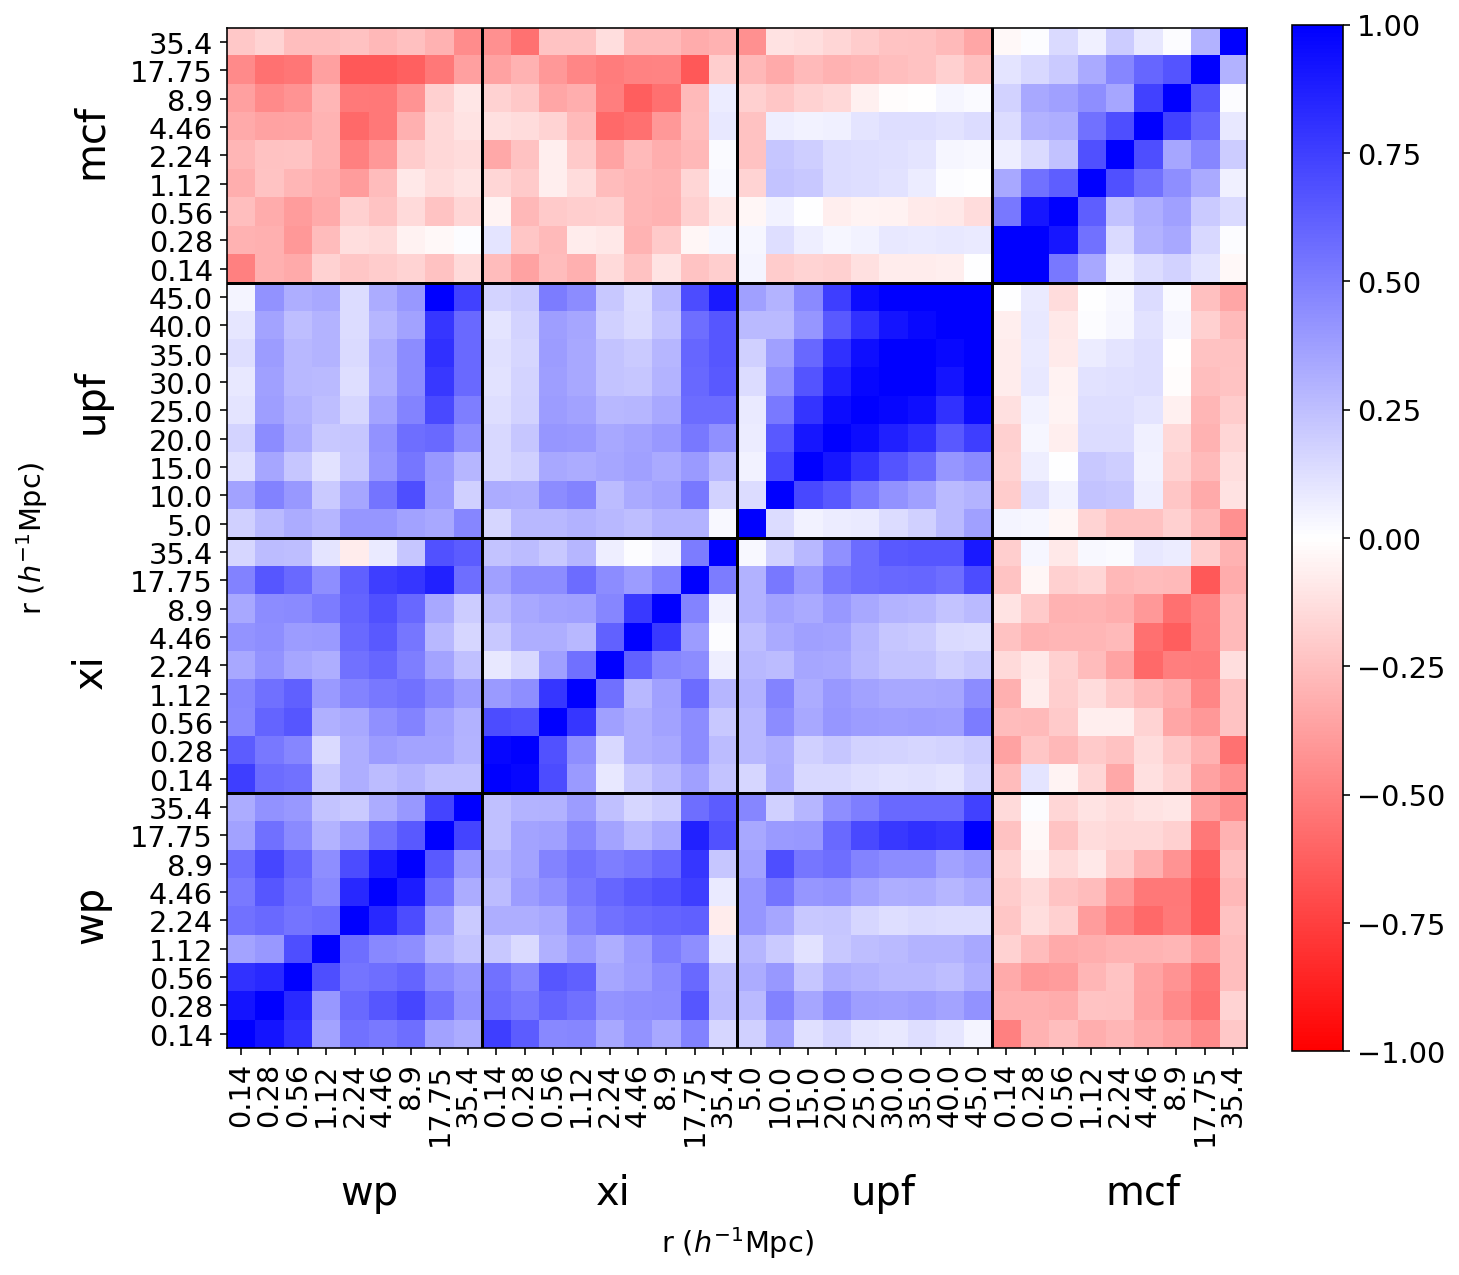

In [16]:
cov_emu = cov_emuperf - cov_glam_scaled
corr_emu = utils.reduced_covariance(cov_emu)
plot_correlation_matrix(corr_emu, statistics_all)

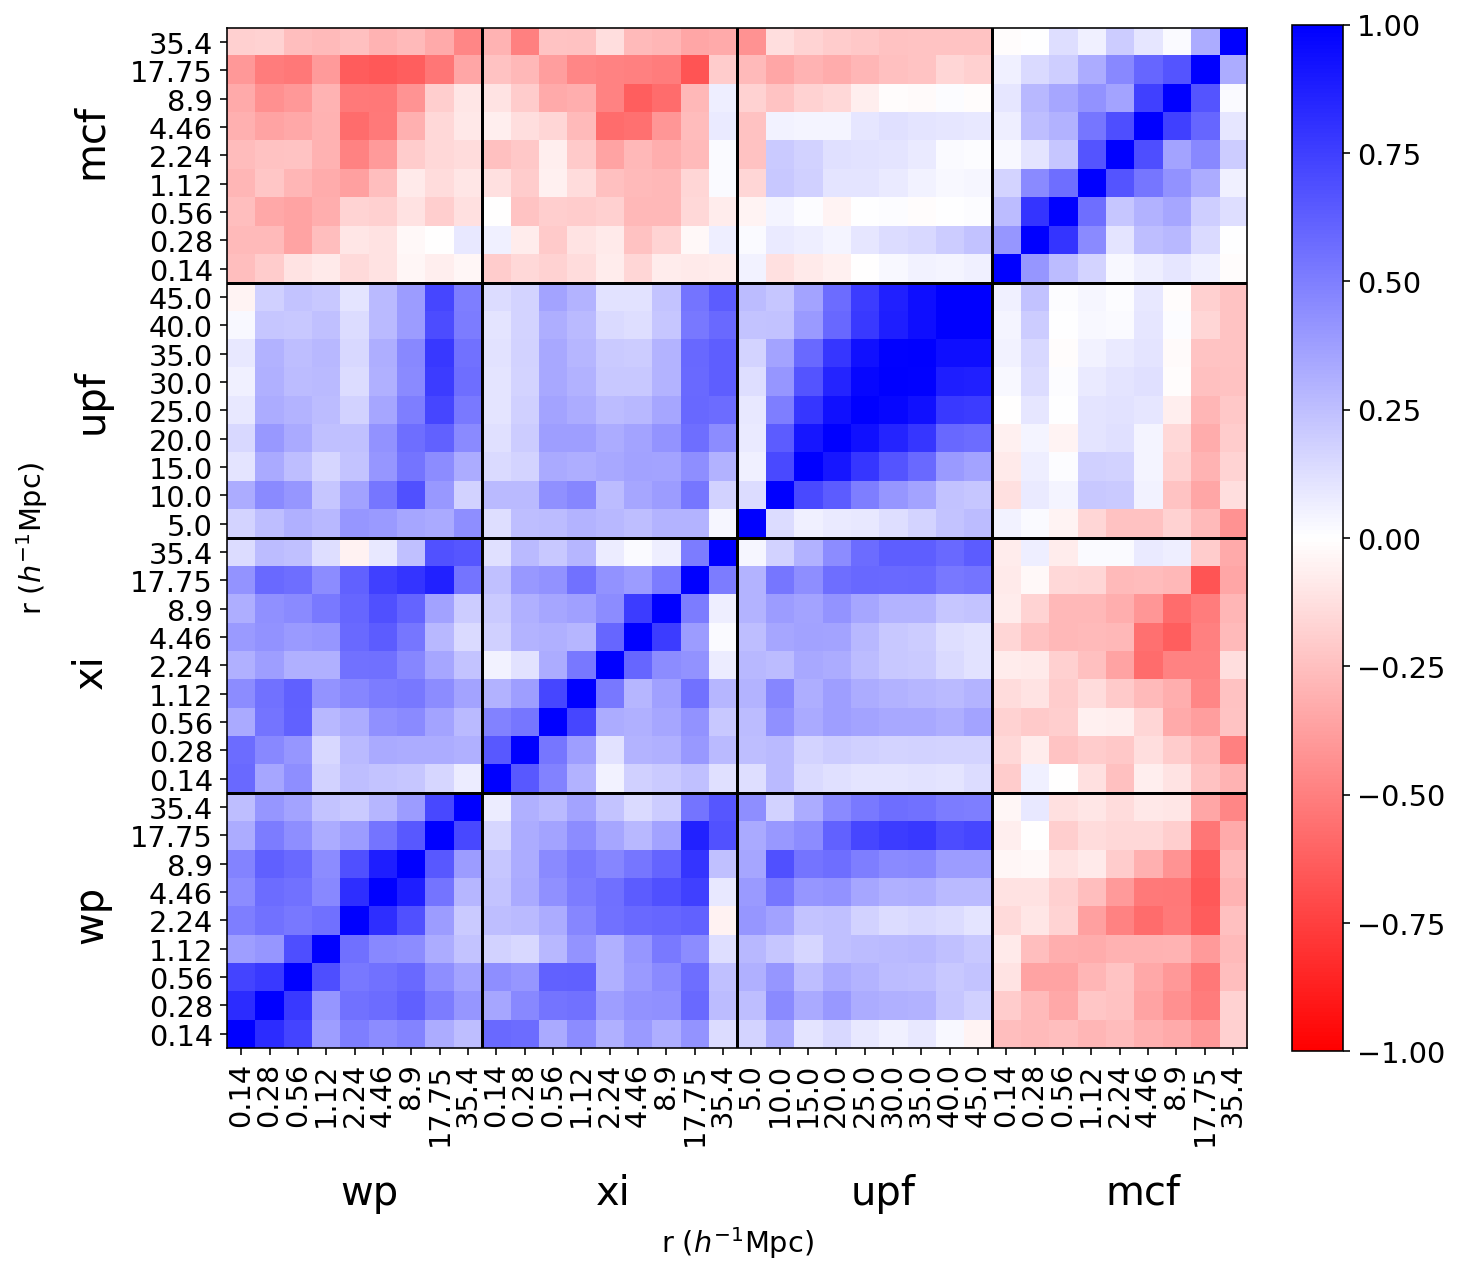

In [17]:
cov_likelihood = cov_emu + cov_aemulus_5box #??
corr_likelihood = utils.reduced_covariance(cov_likelihood)
plot_correlation_matrix(corr_likelihood, statistics_all)

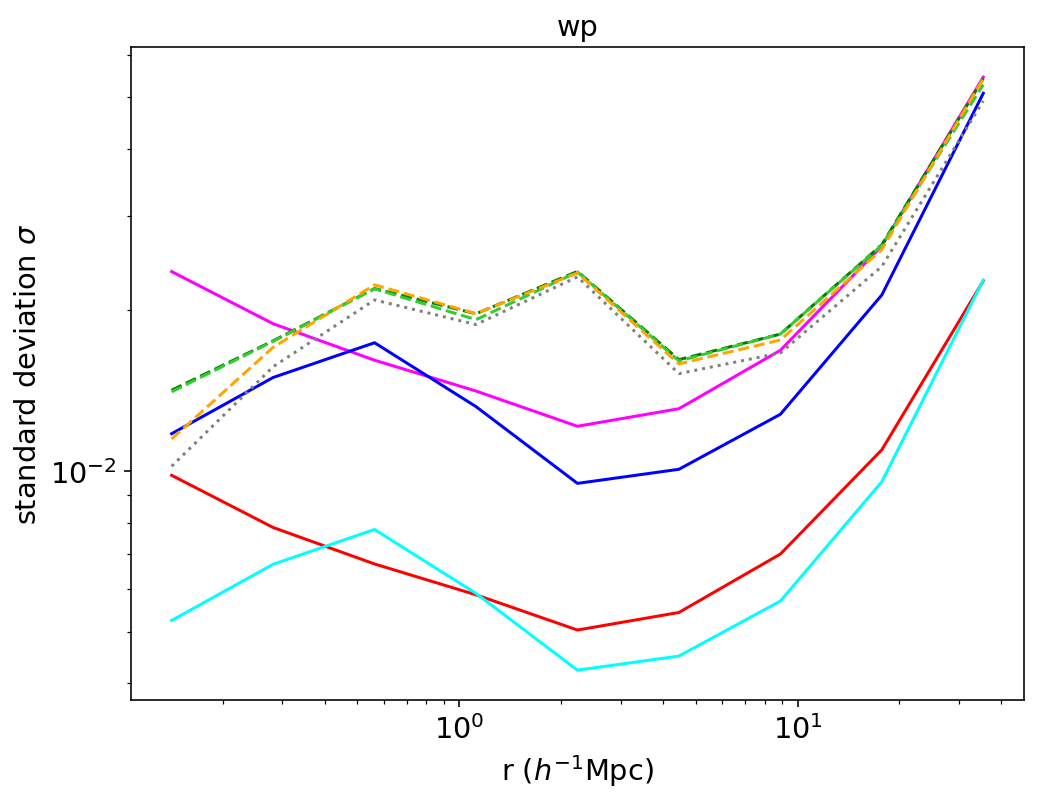

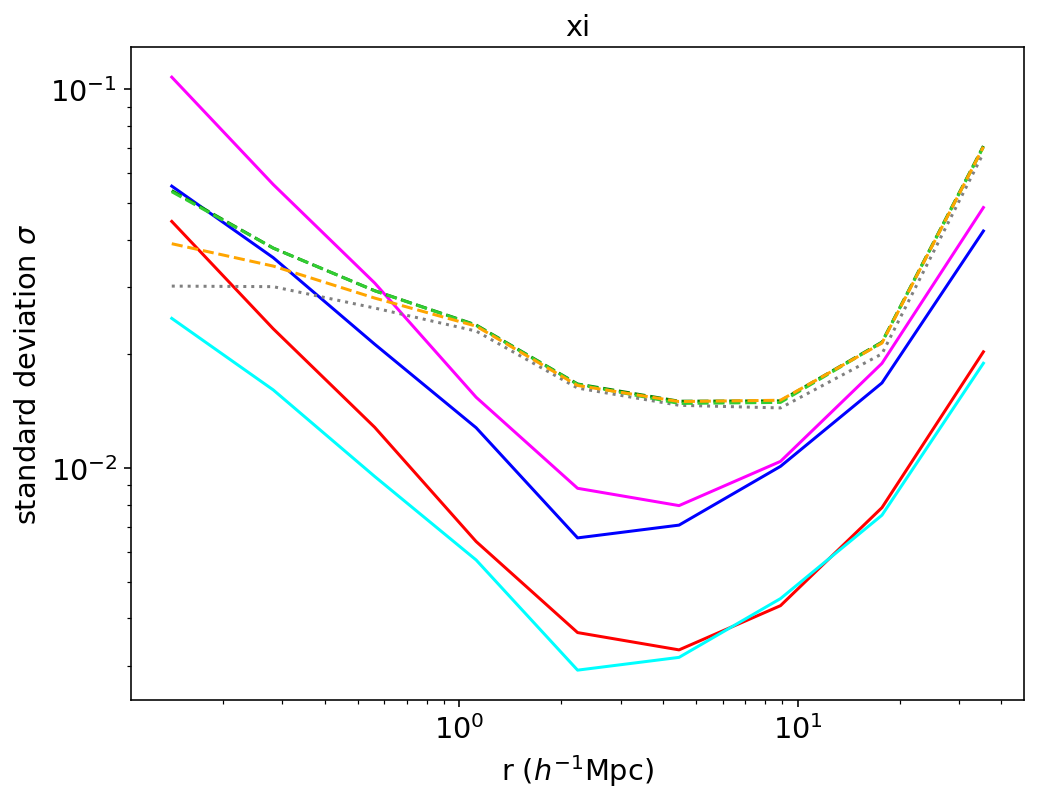

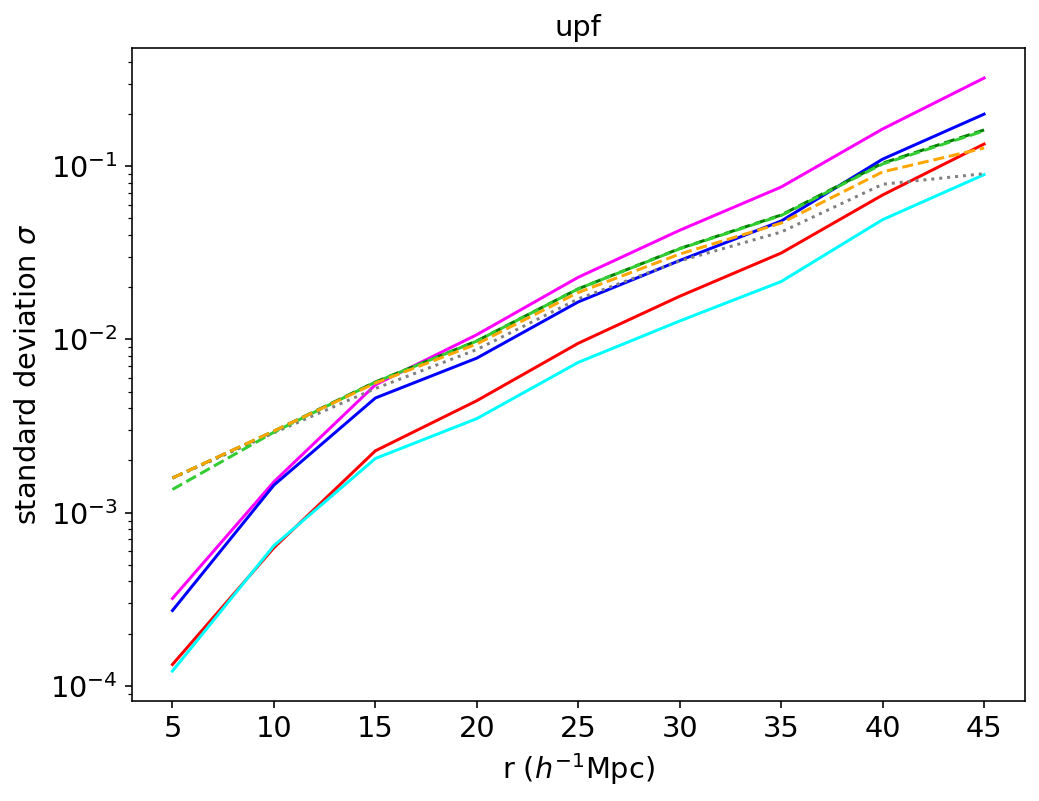

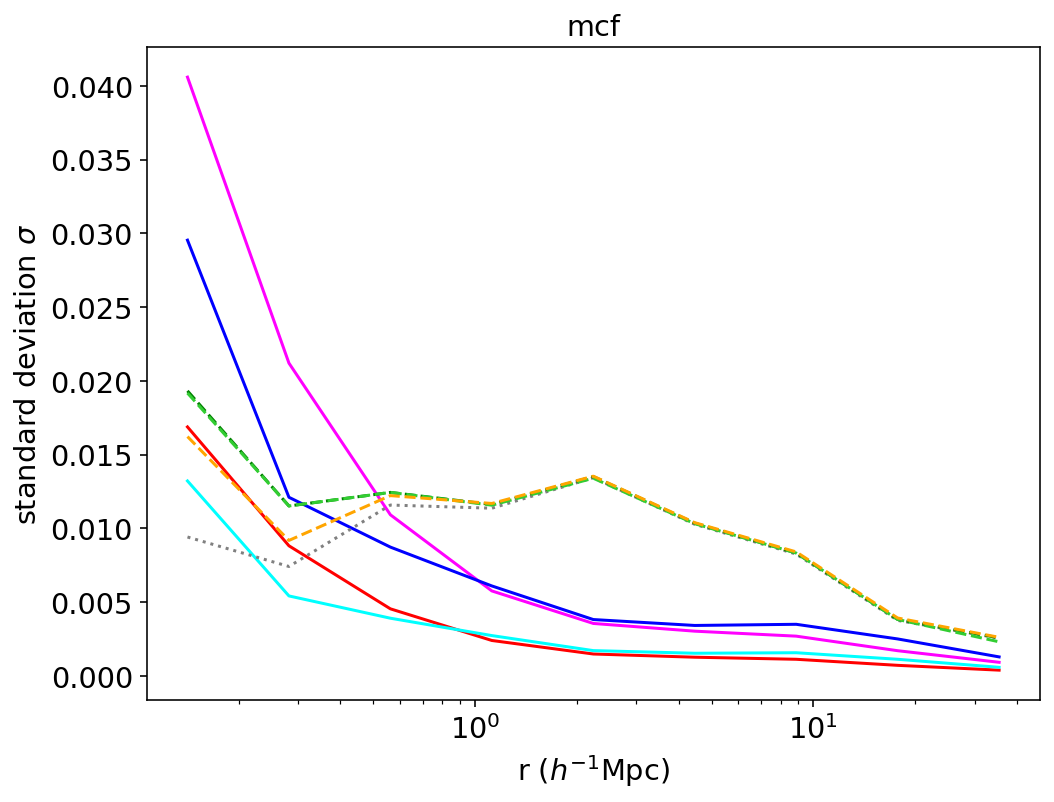

In [36]:
covs = [cov_glam, cov_glam_scaled, cov_aemulus, cov_aemulus_5box, cov_emu, 
        cov_emuperf, cov_emuperf_nonzeromean, cov_likelihood]
colors = [color_glam, 'red', color_aemulus, 'cyan', 'grey', color_emuperf, 'limegreen', 'orange']
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          r'$C_\mathrm{perfnzmean,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAM} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$']
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=True,
                         show_legend=False)

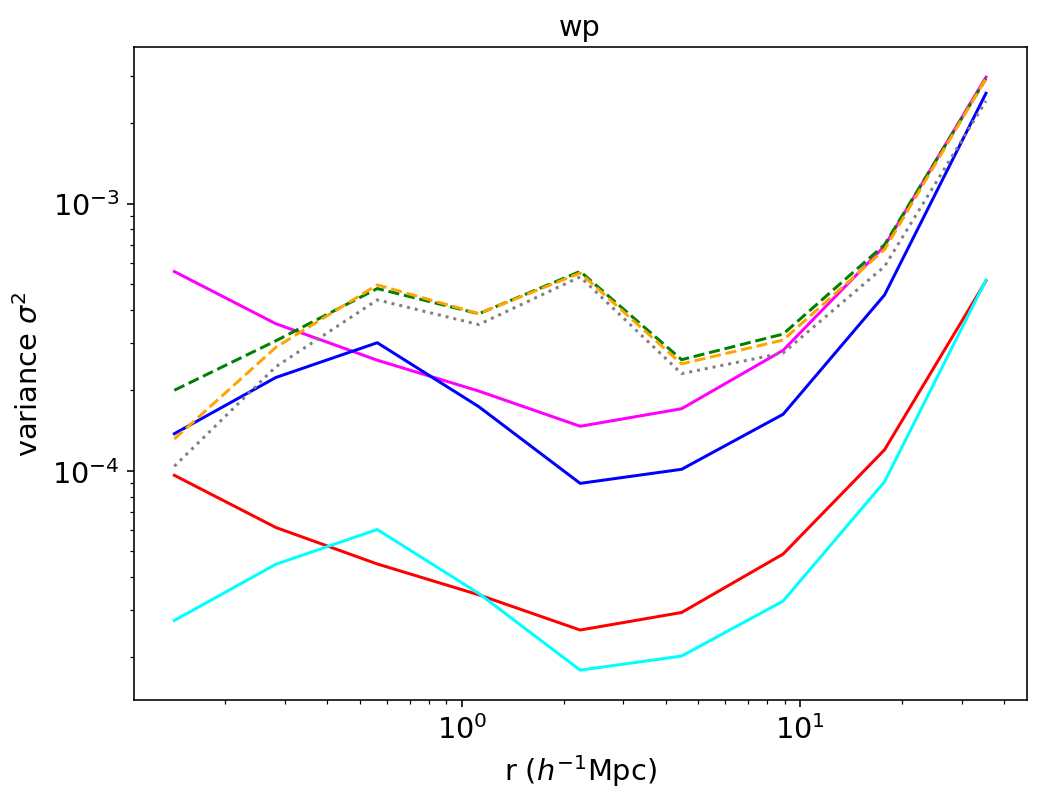

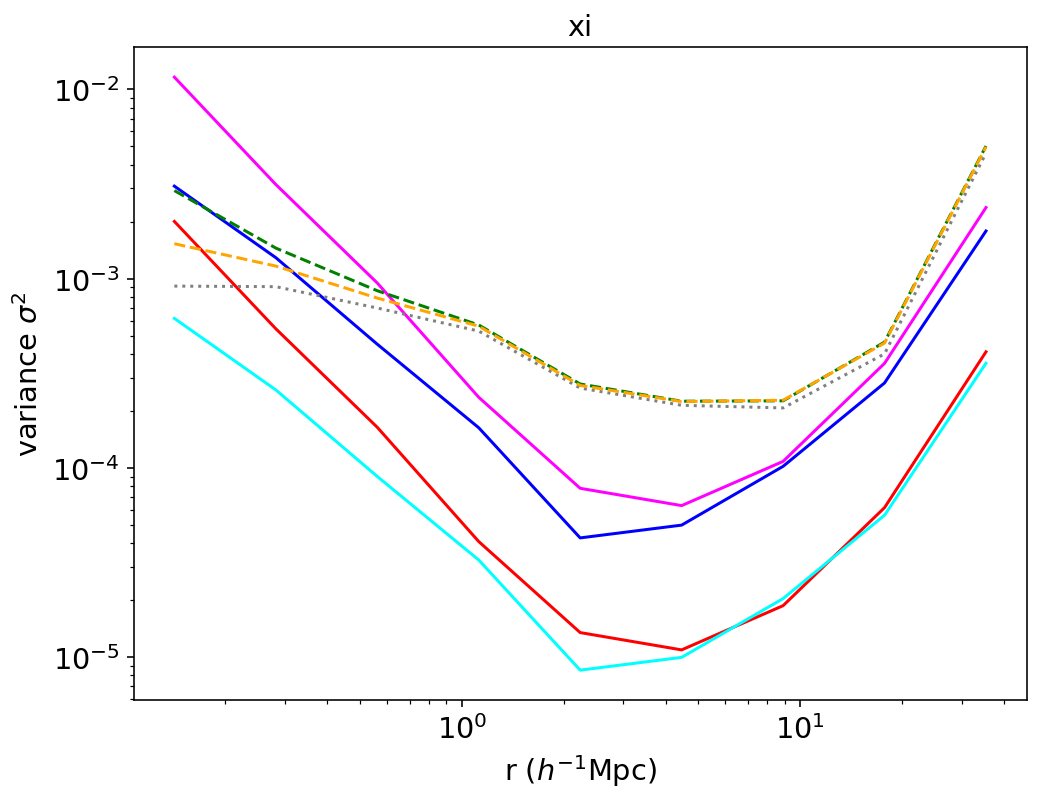

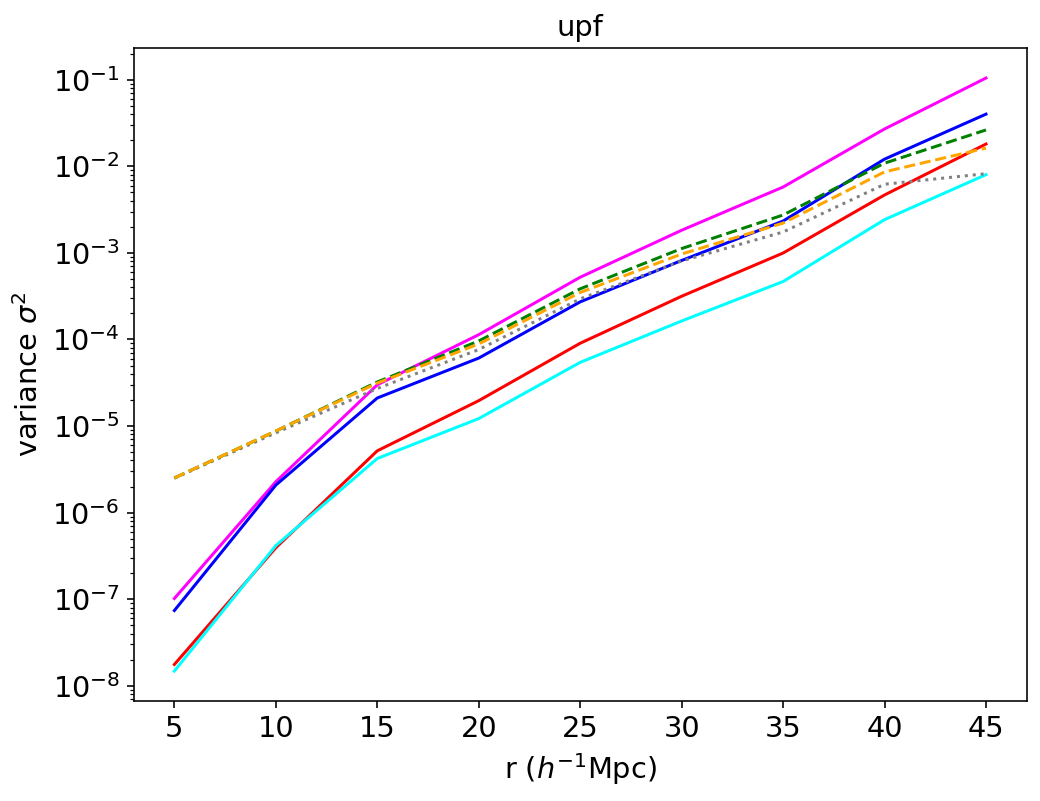

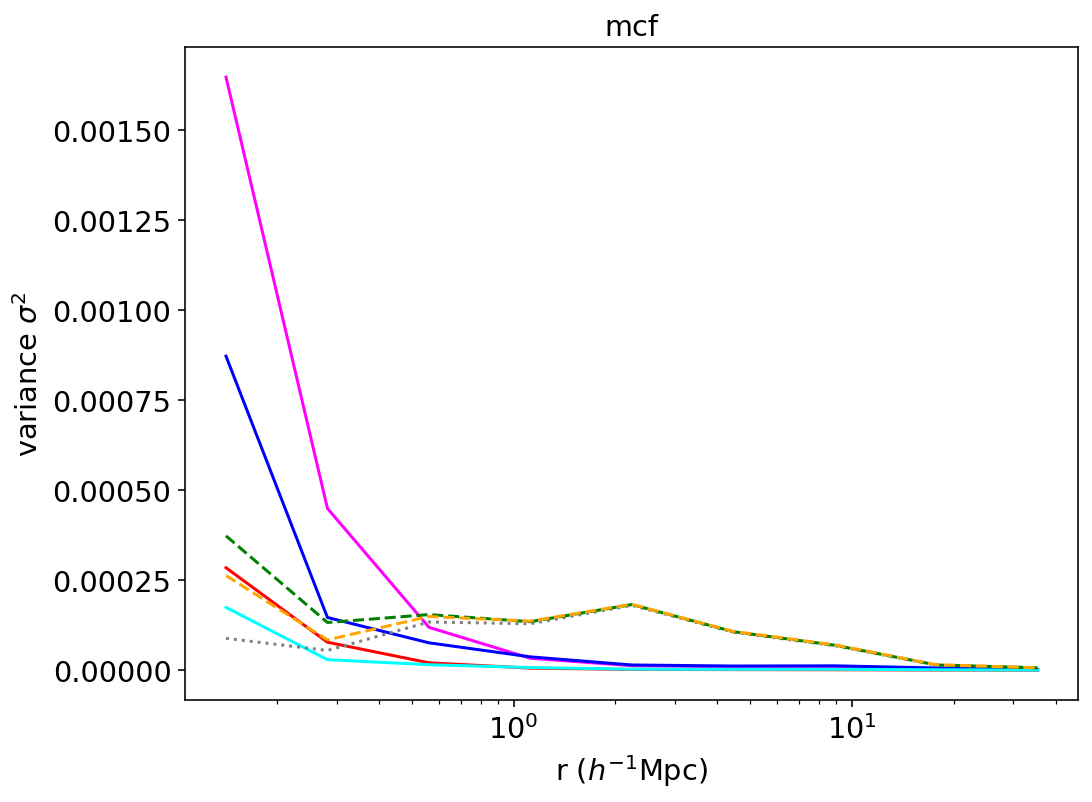

In [16]:
covs = [cov_glam, cov_glam_scaled, cov_aemulus, cov_aemulus_5box, cov_emu, cov_emuperf, cov_likelihood]
colors = [color_glam, 'red', color_aemulus, 'cyan', 'grey', color_emuperf, 'orange']
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAM} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$']
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=False,
                         show_legend=False)

## Check condition numbers

In [51]:
print(1./np.linalg.cond(cov_aemulus))
print(1./np.linalg.cond(cov_aemulus_5box))
print(1./np.linalg.cond(cov_glam))
print(1./np.linalg.cond(cov_emuperf))

3.0082957537794405e-20
5.319658613737054e-21
6.487693265485251e-07
2.5143223625399204e-05


In [48]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_w))
cov_emuperf_wx = get_cov(['wp', 'xi'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wx))
cov_emuperf_wxu = get_cov(['wp', 'xi', 'upf'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wxu))
cov_emuperf_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
print(1./np.linalg.cond(cov_emuperf_wxum))

0.006960826642745742
0.0029448005060714803
3.051073462031662e-05
2.5143223625399204e-05


In [49]:
cov_glam_w = get_cov(['wp'], 'glam')
print(1./np.linalg.cond(cov_glam_w))
cov_glam_wx = get_cov(['wp', 'xi'], 'glam')
print(1./np.linalg.cond(cov_glam_wx))
cov_glam_wxu = get_cov(['wp', 'xi', 'upf'], 'glam')
print(1./np.linalg.cond(cov_glam_wxu))
cov_glam_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'glam')
print(1./np.linalg.cond(cov_glam_wxum))

0.011998391383506966
0.0015349740468683277
6.648243079806474e-07
6.487693265485251e-07


In [50]:
cov_aemulus_w = get_cov(['wp'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_w))
cov_aemulus_wx = get_cov(['wp', 'xi'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wx))
cov_aemulus_wxu = get_cov(['wp', 'xi', 'upf'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wxu))
cov_aemulus_wxum = get_cov(['wp', 'xi', 'upf', 'mcf'], 'aemulus', tag_str='_hod3_test0')
print(1./np.linalg.cond(cov_aemulus_wxum))

0.006250711514400252
0.0005074919944692167
4.3520492693581084e-08
3.0082957537794405e-20


In [43]:
cov_combined = get_cov(statistics_all, 'combined_glam')

[ 1.31443686e-04  1.61160533e-04  1.86779185e-04  8.45923406e-05
  1.36363570e-04  8.17509294e-05  9.63069795e-05  9.66019954e-05
  1.58194366e-04  2.62119956e-04  2.25121682e-04  1.08039219e-04
  1.22080976e-04  5.84750902e-05  6.77636951e-05  5.47287510e-05
  1.02104858e-04  1.12382354e-04  3.00643288e-06  1.09763022e-05
  6.71055421e-06  1.64056936e-05  1.99821982e-05  2.22927585e-05
  4.71029301e-05  2.58531922e-05 -6.56596692e-05 -4.73744905e-05
 -2.82466959e-05 -3.54013448e-05 -3.80355198e-05 -4.07609827e-05
 -3.66156699e-05 -3.23289744e-05 -1.80561757e-05 -5.58733672e-06]
[ 1.31443686e-04  1.61160533e-04  1.86779185e-04  8.45923406e-05
  1.36363570e-04  8.17509294e-05  9.63069795e-05  9.66019954e-05
  1.58194366e-04  2.62119956e-04  2.25121682e-04  1.08039219e-04
  1.22080976e-04  5.84750902e-05  6.77636951e-05  5.47287510e-05
  1.02104858e-04  1.12382354e-04  3.00643288e-06  1.09763022e-05
  6.71055421e-06  1.64056936e-05  1.99821982e-05  2.22927585e-05
  4.71029301e-05  2.5853

In [46]:
print(np.linalg.cond(cov_combined))
print(1./np.linalg.cond(cov_combined))

31044.798865324843
3.221151486076914e-05


In [ ]:
eigs = la.eig(cov_glam_w)[0]
k = la.norm(eigs-eigsp)/la.norm(perturb)    # Absolute condition number
print(k)
kr = k*la.norm(M)/la.norm(eigs)  # Relative condition number
print(kr)

## Eigendecompose emu cov matrix

Let's practice on just the wp emu covmat:

In [52]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
cov_glam_w = get_cov(['wp'], 'glam')
cov_glam_scaled_w = cov_glam_w*(1/5)*(L_glam/L_aemulus)**3
cov_emu_w = cov_emuperf_w - cov_glam_scaled_w

In [53]:
#print(cov_emu_w)

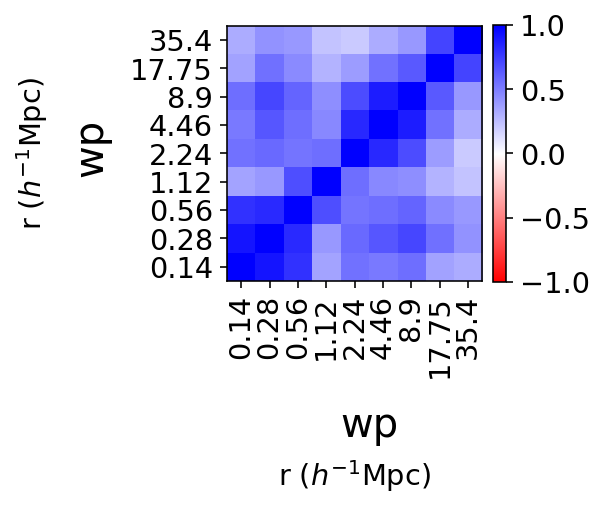

In [54]:
corr_emu_w = utils.reduced_covariance(cov_emu_w)
plot_correlation_matrix(corr_emu_w, ['wp'])

In [55]:
# recenter on zero (mean of columns)
#cov_emu_mean0_w = cov_emu_w - np.mean(cov_emu_w, axis=0)
#cov_emu_mean0_w -= np.mean(cov_emu_mean0_w, axis=1)
#assert np.all(np.mean(cov_emu_mean0_w, axis=
#print(np.mean(cov_emu_mean0_w, axis=0))
#print(cov_emu_mean0_w)

In [56]:
eigvals, eigvecs = np.linalg.eig(cov_emu_w)
print(eigvals)

[3.21753493e-03 1.10899062e-03 3.13497600e-04 2.27920467e-04
 1.78019071e-04 7.73008988e-05 6.43317065e-06 2.93775697e-05
 1.68755272e-05]


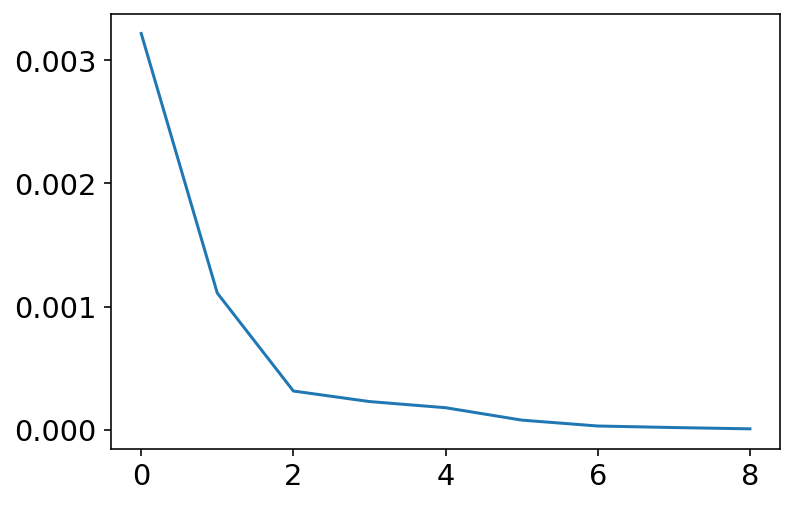

In [57]:
# plot eigenvalues
plt.plot(np.sort(eigvals)[::-1])

In [58]:
# cov mats are real symmetric, so can use the transpose instead of inverse 
cov_emu_decomposed = eigvecs @ np.diag(eigvals) @ eigvecs.T

In [61]:
#assert np.array_equal(cov_emu_decomposed, cov_emu), "Covs not equal!"
assert np.allclose(cov_emu_decomposed, cov_emu_w), "Covs not close!"

In [136]:
# The eigenvalues are not sorted! So find top ones.
n_largest = 4
idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
idxs_largest = np.sort(idxs_largest)
print(idxs_largest)

[0 1 2 3]


In [137]:
eigvals_largest = [eigvals[i] if i in idxs_largest else 0 for i in range(len(eigvals))]   

In [140]:
cov_emu_largest_orig = eigvecs @ np.diag(eigvals_largest) @ eigvecs.T
#print(eigvecs[idxs_largest])
c = eigvecs[:,idxs_largest]
print(cov_emu_w.shape, c.shape)
w = cov_emu_w @ c
#print(w)
cov_emu_largest = w @ c.T
assert np.allclose(cov_emu_largest, cov_emu_largest_orig), "Covs not close!"
#assert np.allclose(cov_emu_largest, cov_emu_w), "Covs not close!"

(9, 9) (9, 4)


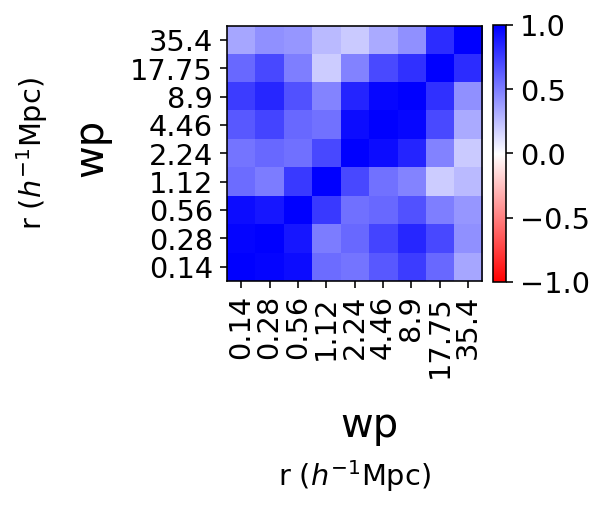

In [142]:
corr_emu_largest_orig = utils.reduced_covariance(cov_emu_largest_orig)
plot_correlation_matrix(corr_emu_largest_orig, ['wp'])

In [30]:
def plot_eigenvalues(cov):
    eigvals, eigvecs = np.linalg.eig(cov)
    plt.figure(figsize=(4,3))
    plt.plot(np.sort(eigvals)[::-1], marker='o', markersize=6)
    plt.xlabel("component")
    plt.ylabel(f"eigenvalue $\lambda$")
    return plt.gca()

In [31]:
def eigendecomp(cov, n_largest):
    eigvals, eigvecs = np.linalg.eig(cov)
    # The eigenvalues are not sorted! So find top ones.
    idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
    idxs_largest = np.sort(idxs_largest)
    
    eigvals_largest = [eigvals[i] if i in idxs_largest else 0 for i in range(len(eigvals))] 
    cov_largest = eigvecs @ np.diag(eigvals_largest) @ eigvecs.T
    return cov_largest

In [32]:
# via http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/
def eigendecomp_v2(cov, n_largest):
    eigvals, eigvecs = np.linalg.eig(cov)
    # The eigenvalues are not sorted! So find top ones.
    idxs_largest = np.argpartition(eigvals, -n_largest)[-n_largest:]
    idxs_largest = np.sort(idxs_largest)
    
    c = eigvecs[:,idxs_largest]
    w = cov @ c
    cov_largest = w @ c.T
    return cov_largest

## aemulus wp

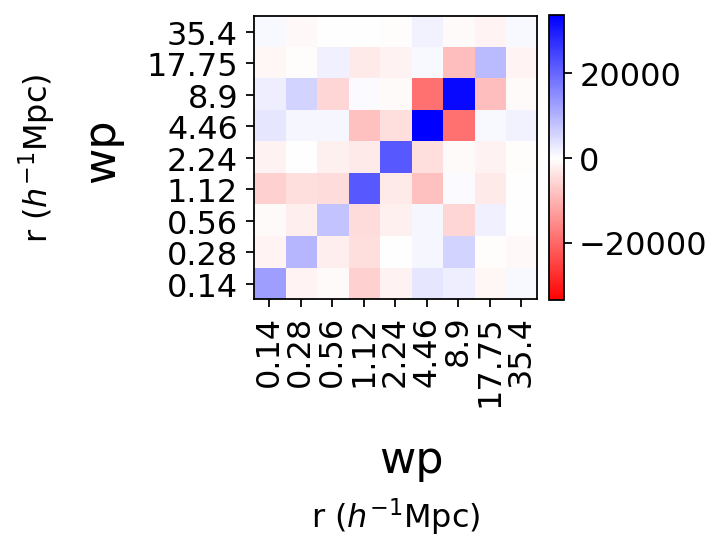

In [240]:
cov_aemulus_w = get_cov(['wp'], 'aemulus', tag_str='_hod3_test0')
icov_aemulus_w = np.linalg.inv(cov_aemulus_w)
#corr_aemulus_w = utils.reduced_covariance(cov_aemulus_w)
plot_icov_matrix(icov_aemulus_w, ['wp'])

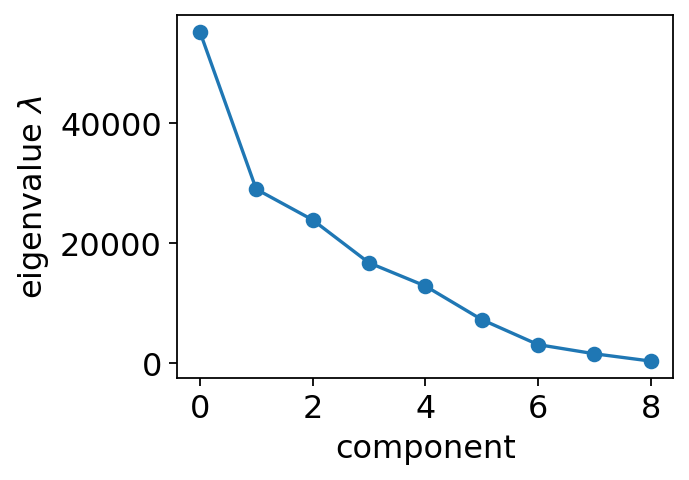

In [241]:
plot_eigenvalues(icov_aemulus_w)

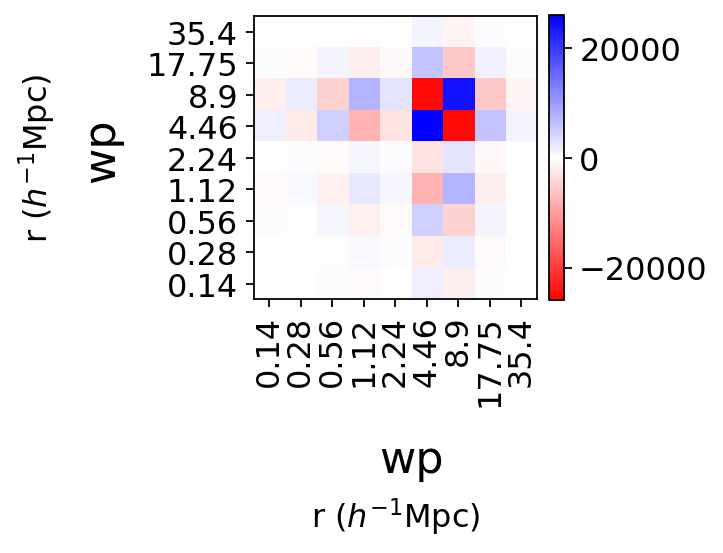

In [245]:
icov_aemulus_w_largest = eigendecomp_v2(icov_aemulus_w, 1)
plot_icov_matrix(icov_aemulus_w_largest, ['wp'])

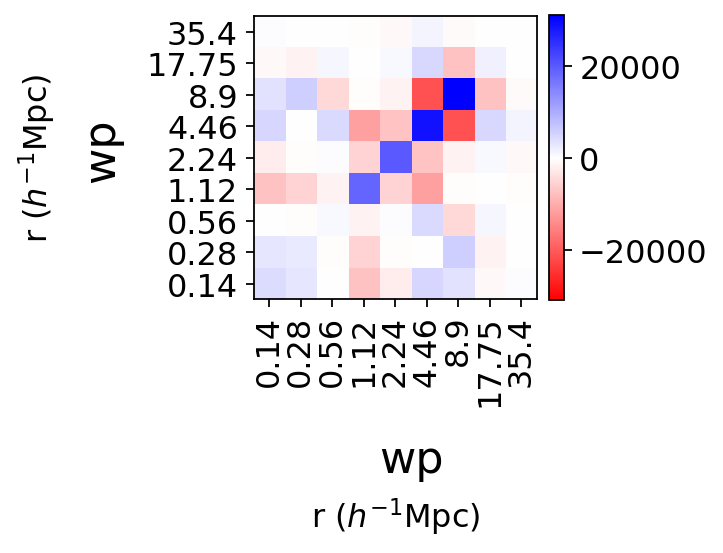

In [248]:
icov_aemulus_w_largest = eigendecomp_v2(icov_aemulus_w, 3)
plot_icov_matrix(icov_aemulus_w_largest, ['wp'])

### glam

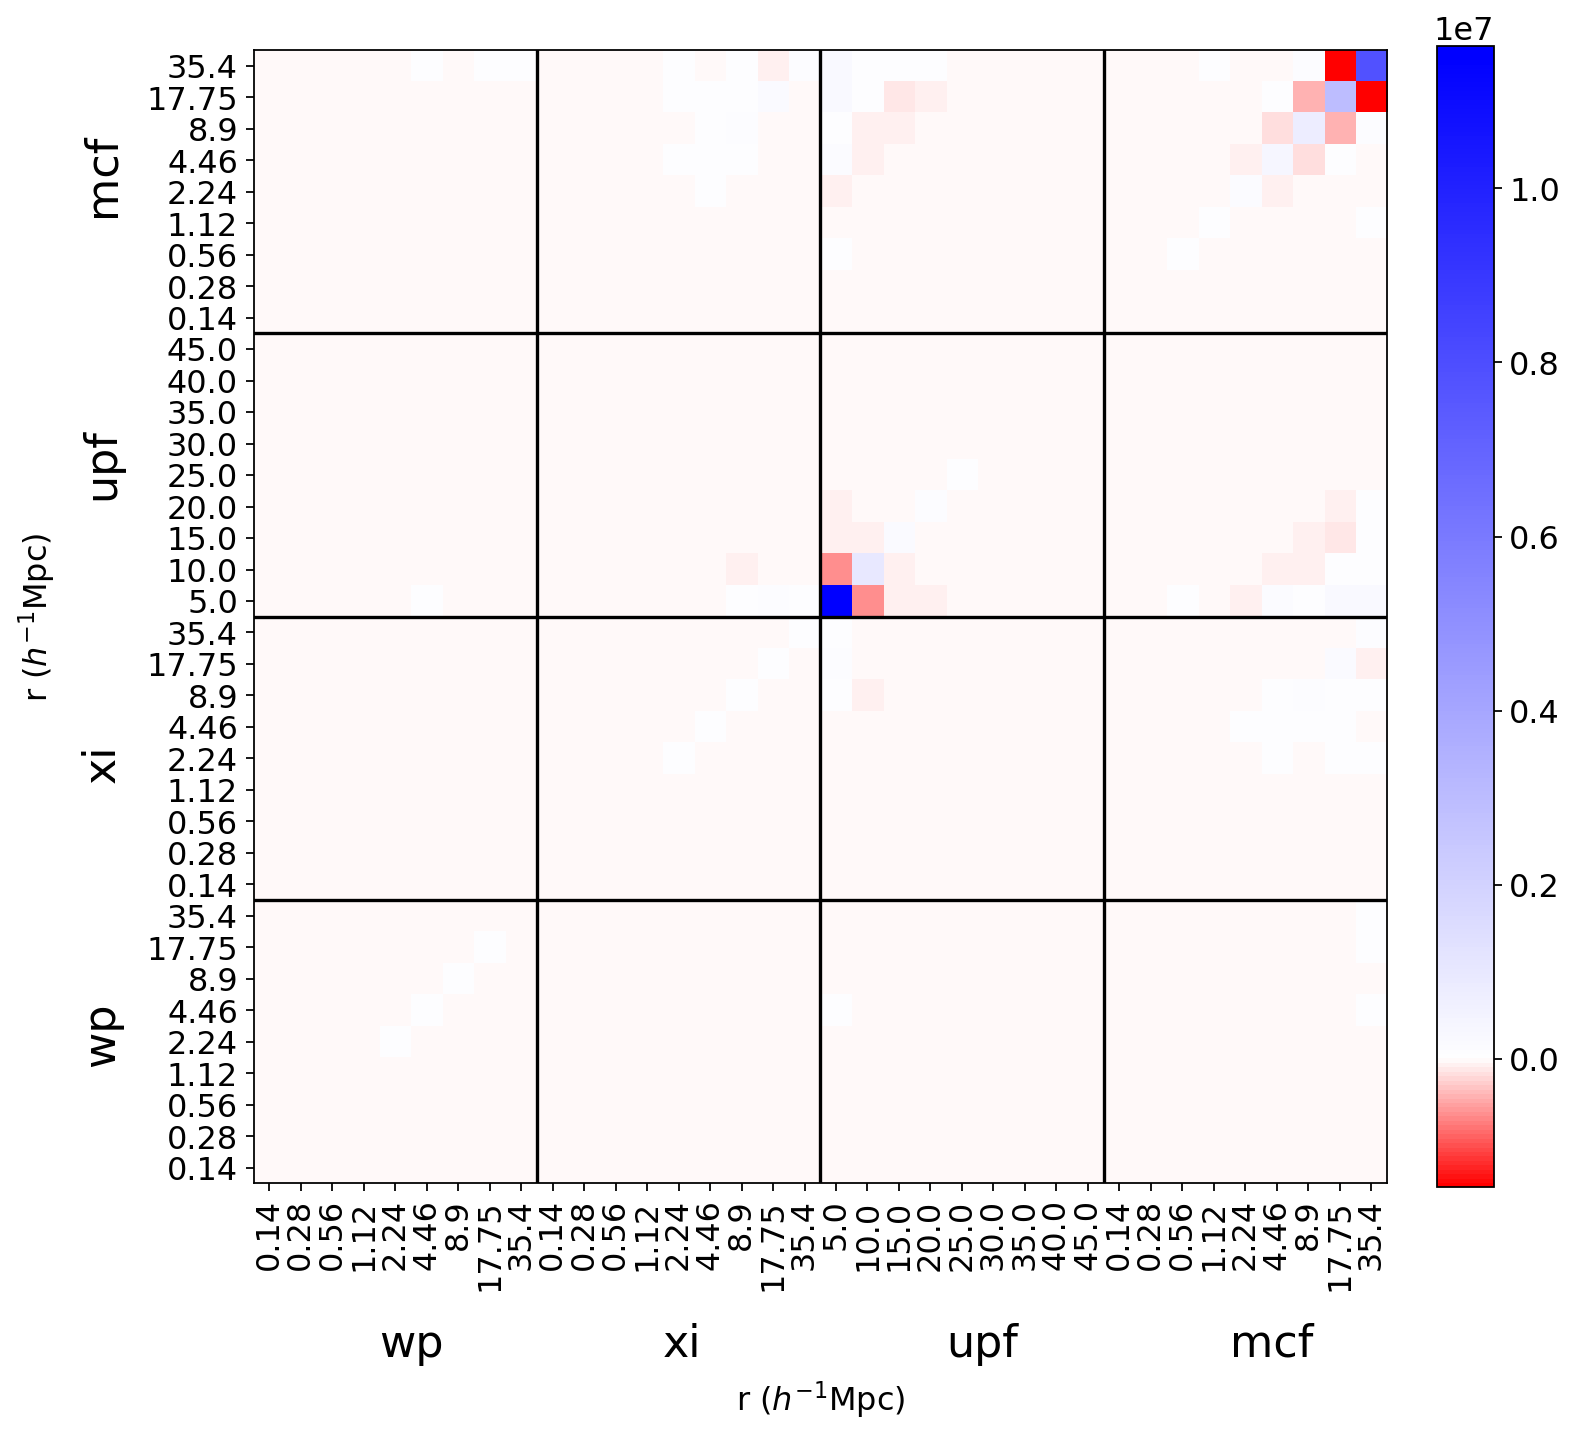

In [258]:
cov_glam = get_cov(statistics_all, 'glam')
icov_glam = np.linalg.inv(cov_glam)
plot_icov_matrix(icov_glam, statistics_all)

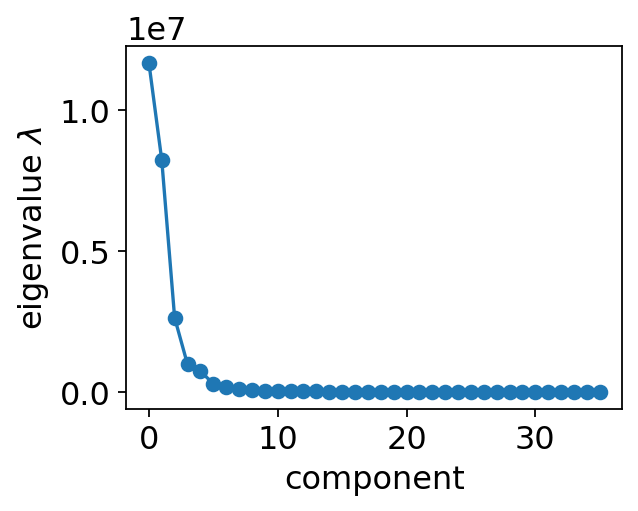

In [259]:
ax = plot_eigenvalues(icov_glam)
#ax.set_yscale('log')

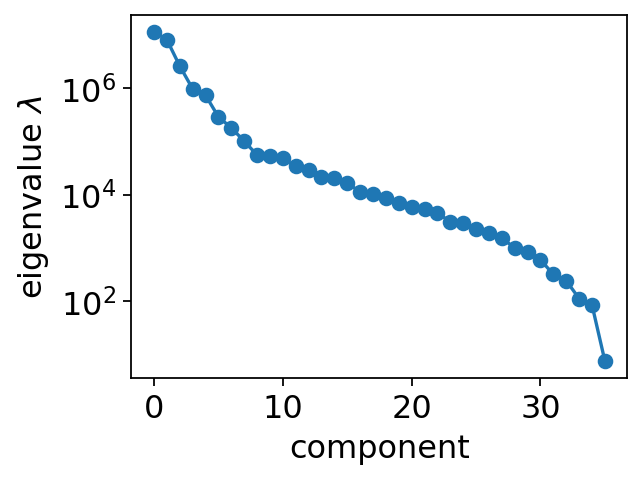

In [260]:
ax = plot_eigenvalues(icov_glam)
ax.set_yscale('log')

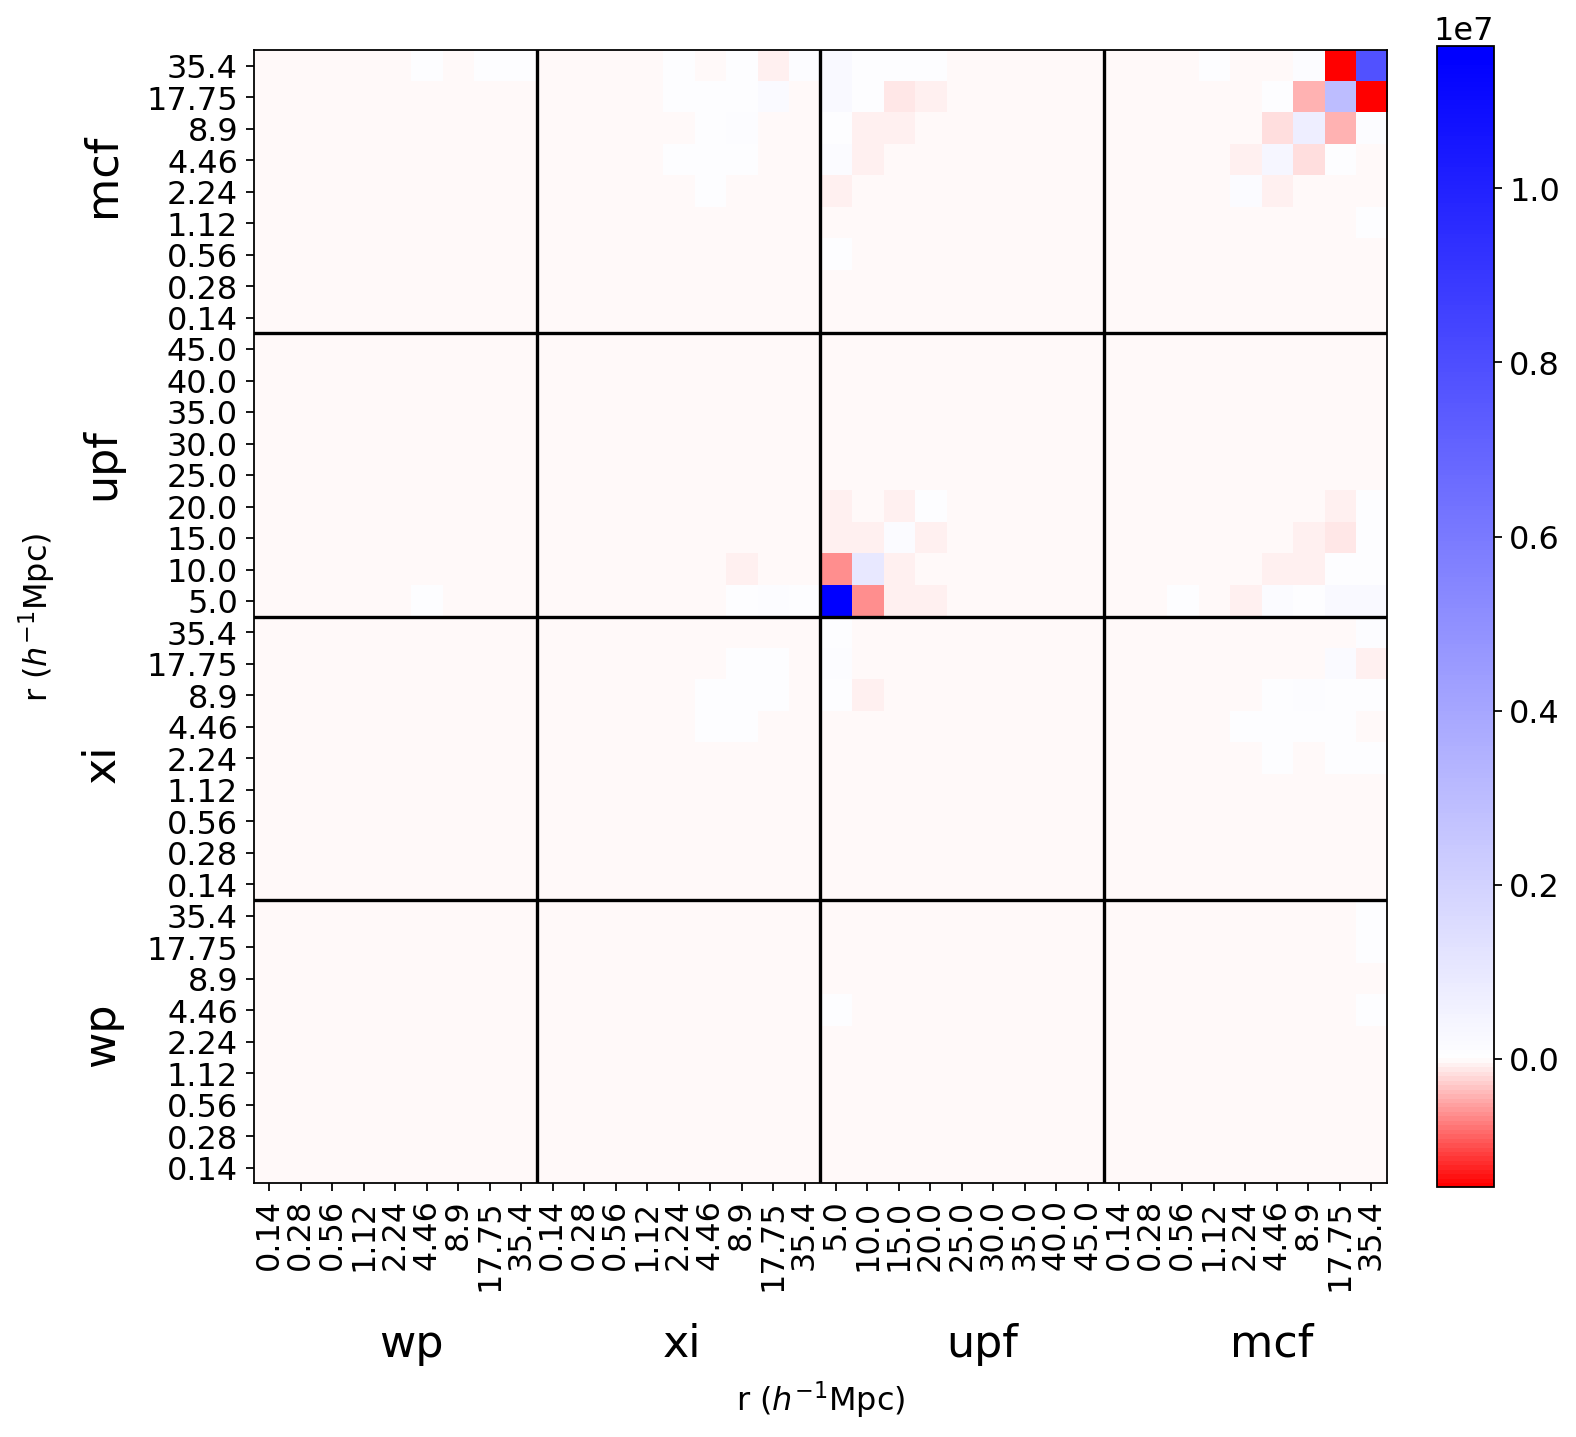

In [267]:
icov_glam_largest = eigendecomp_v2(icov_glam, 8)
plot_icov_matrix(icov_glam_largest, statistics_all)

## emu

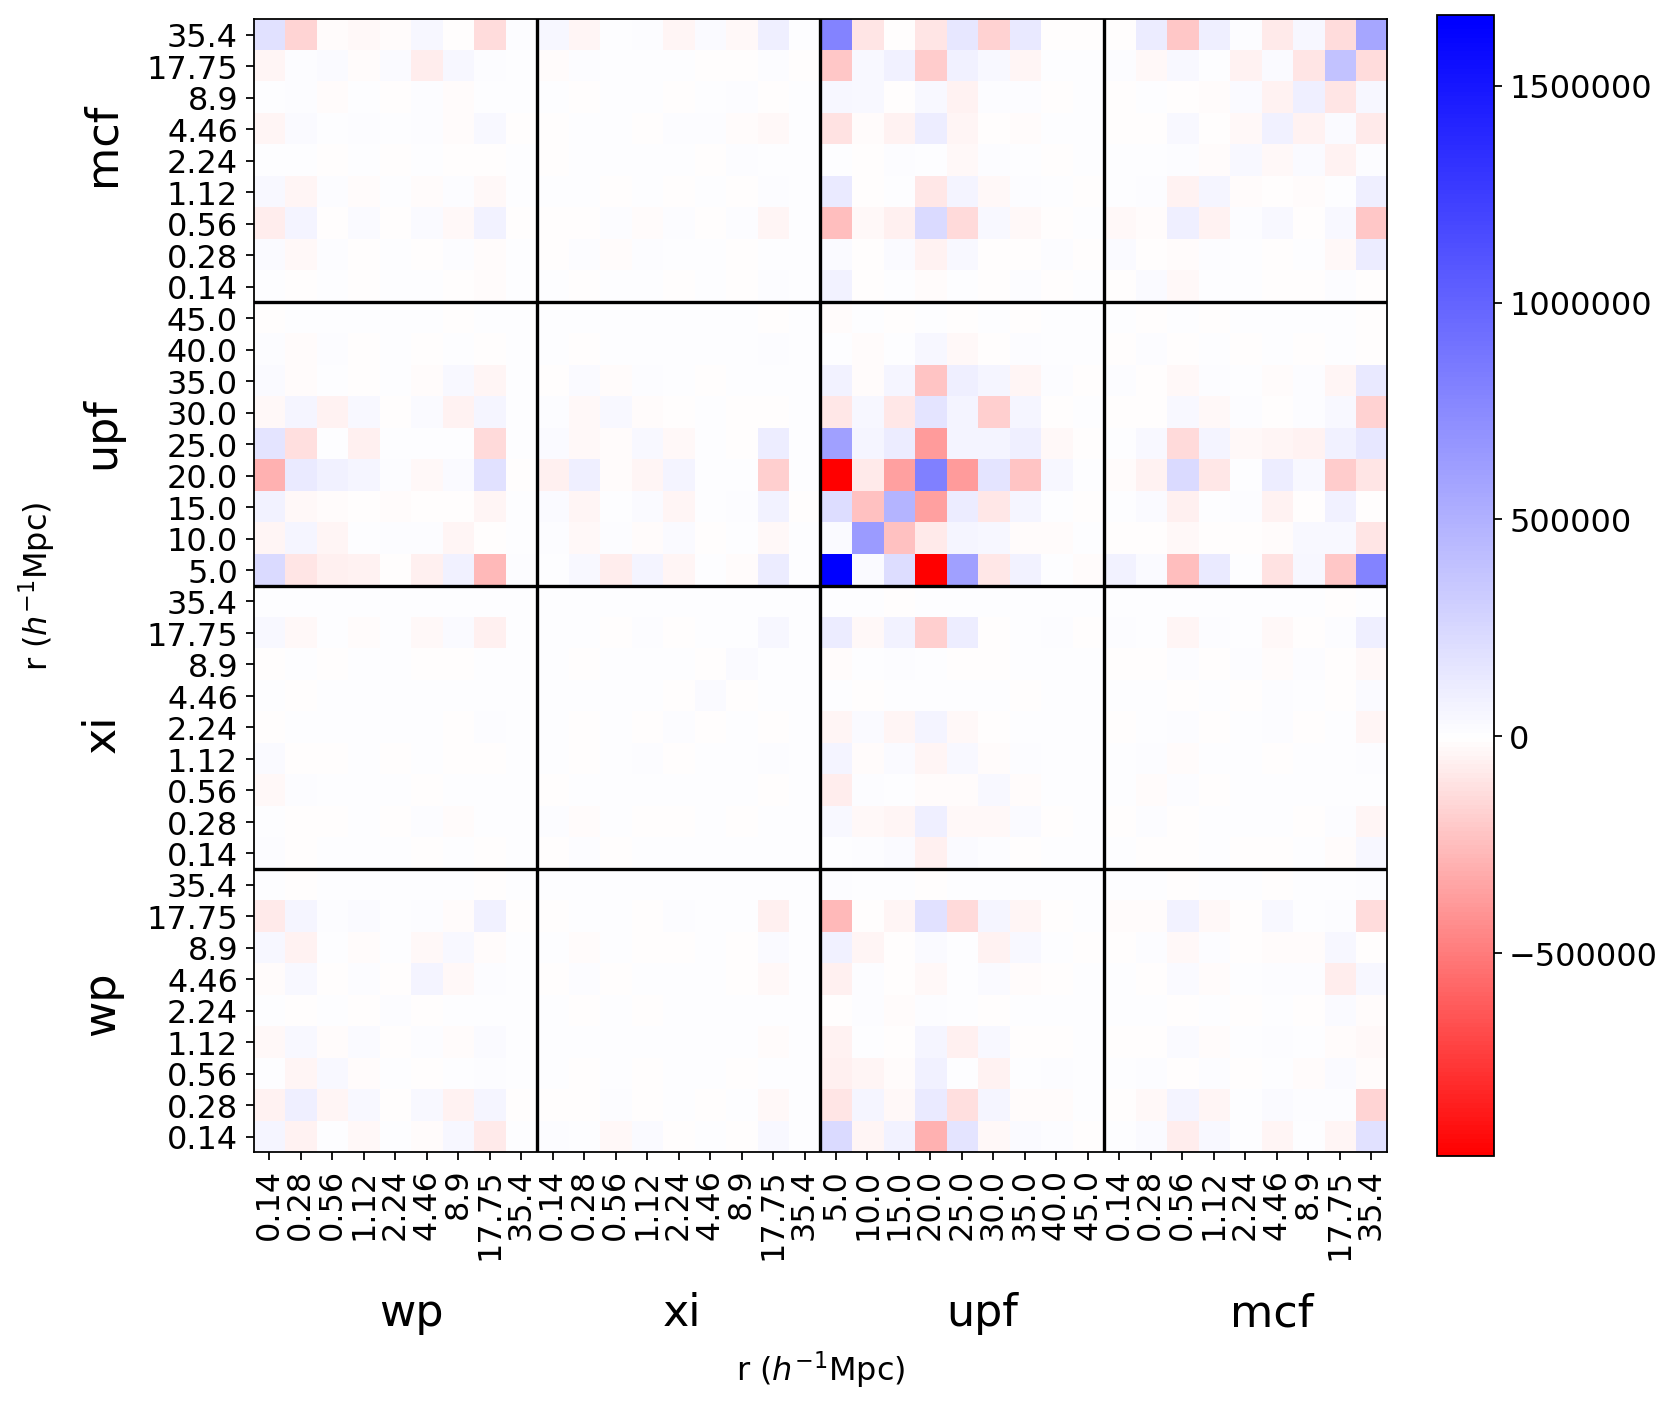

In [28]:
icov_emu = np.linalg.inv(cov_emu)
plot_icov_matrix(icov_emu, statistics_all)

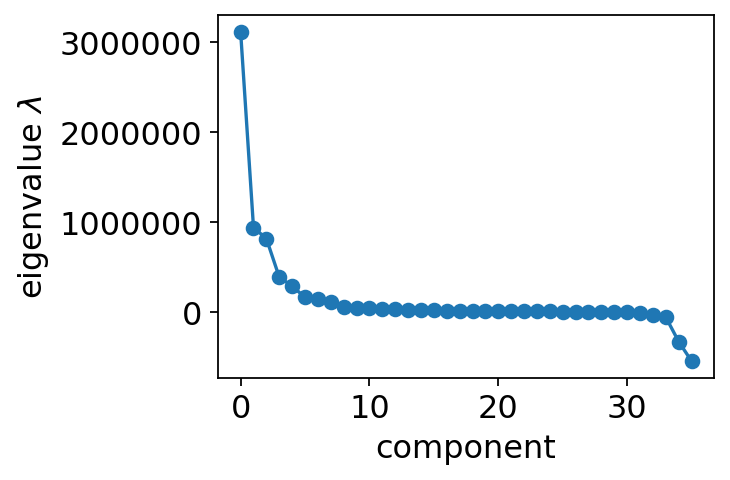

In [33]:
ax = plot_eigenvalues(icov_emu)
#ax.set_yscale('log')

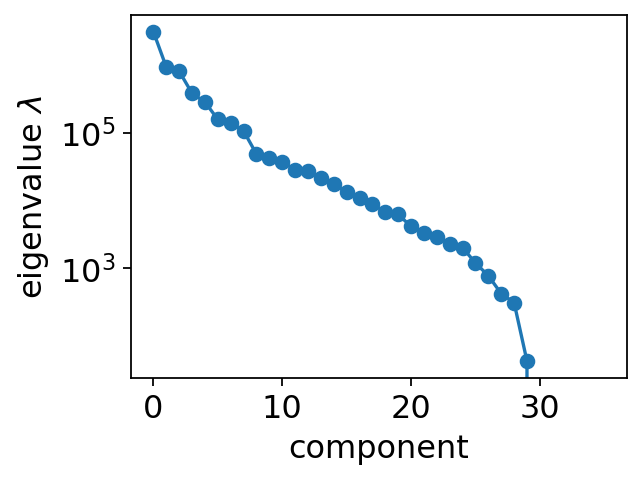

In [34]:
ax = plot_eigenvalues(icov_emu)
ax.set_yscale('log')

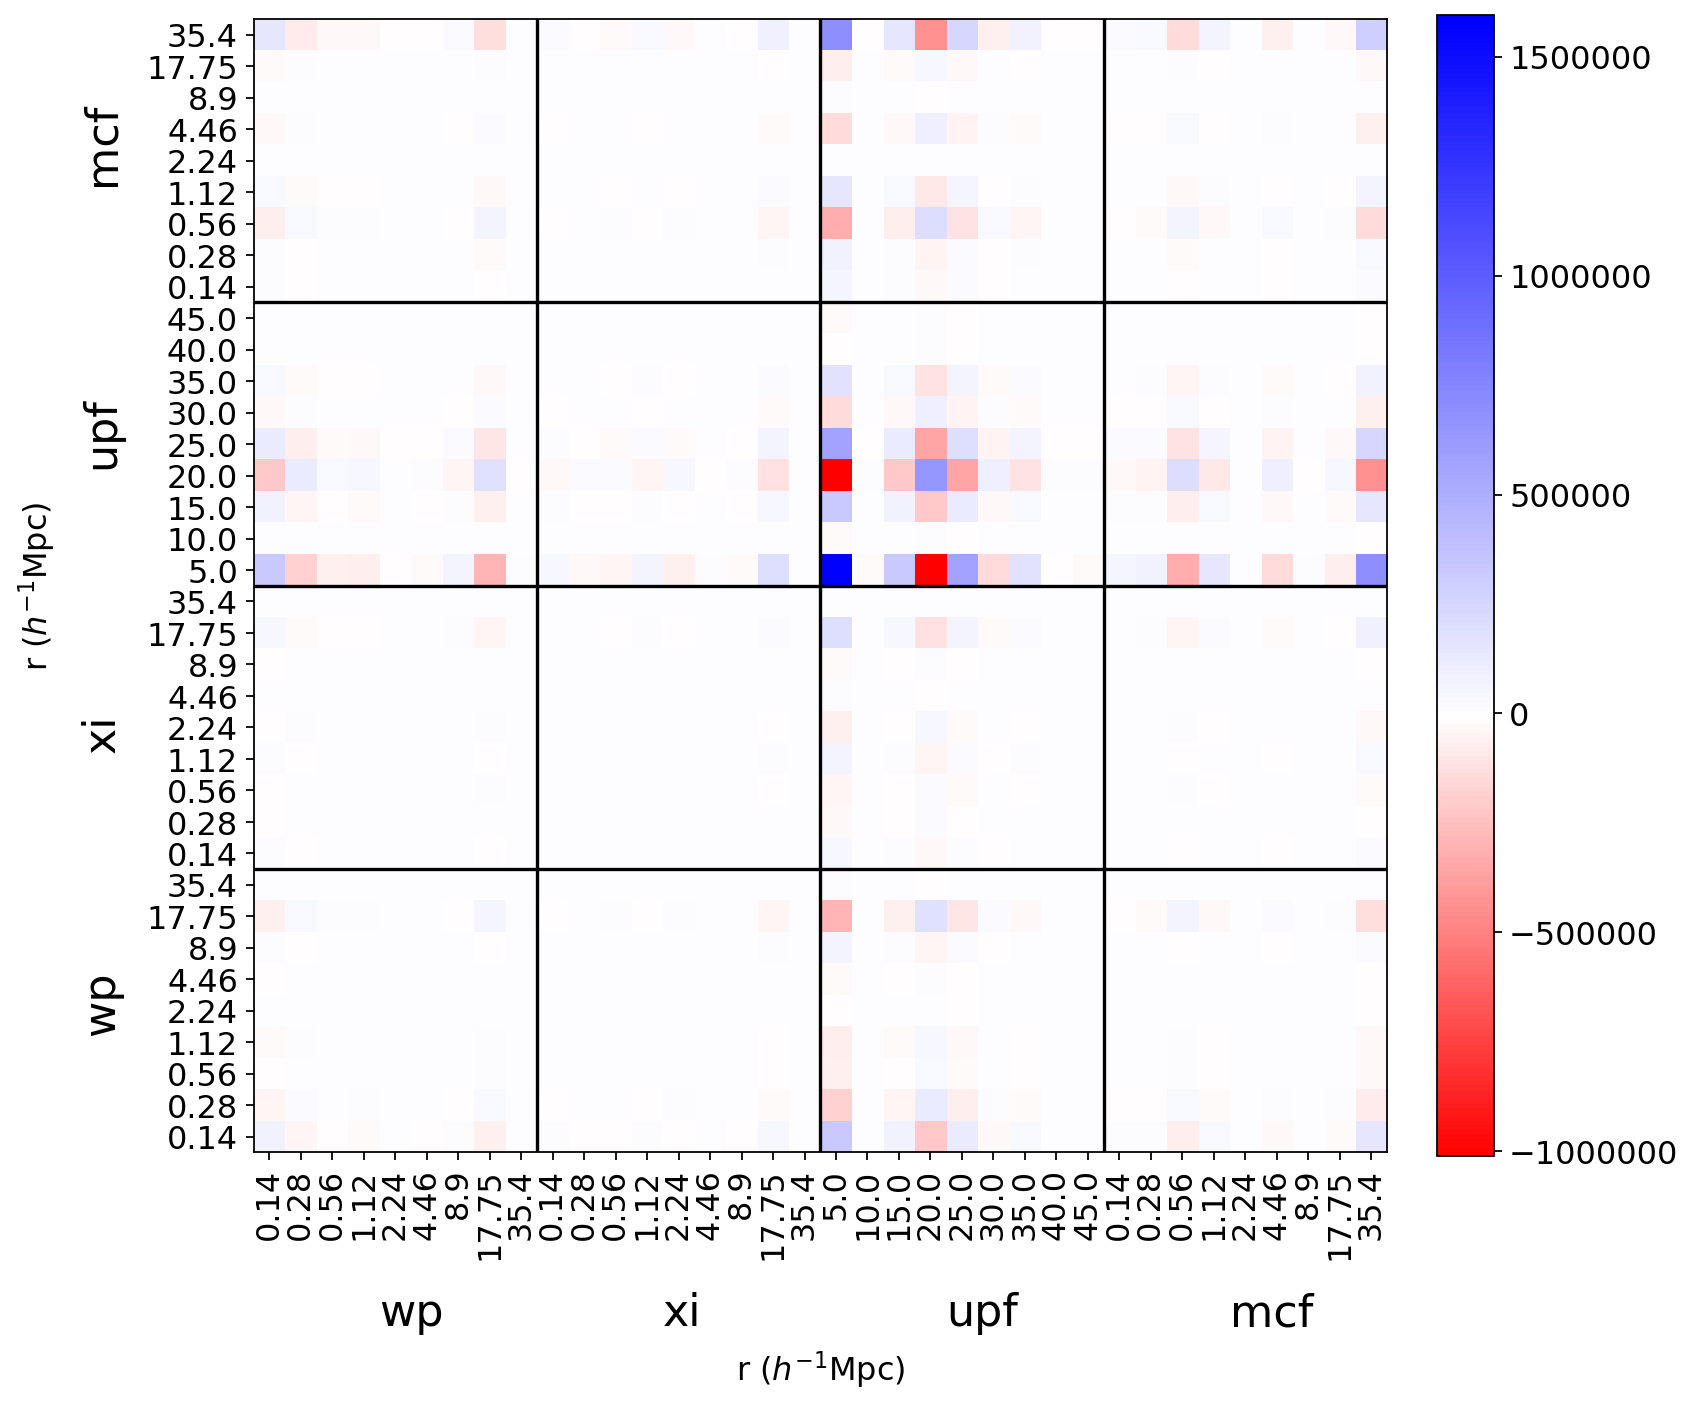

In [36]:
icov_emu_largest = eigendecomp_v2(icov_emu, 1)
plot_icov_matrix(icov_emu_largest, statistics_all)

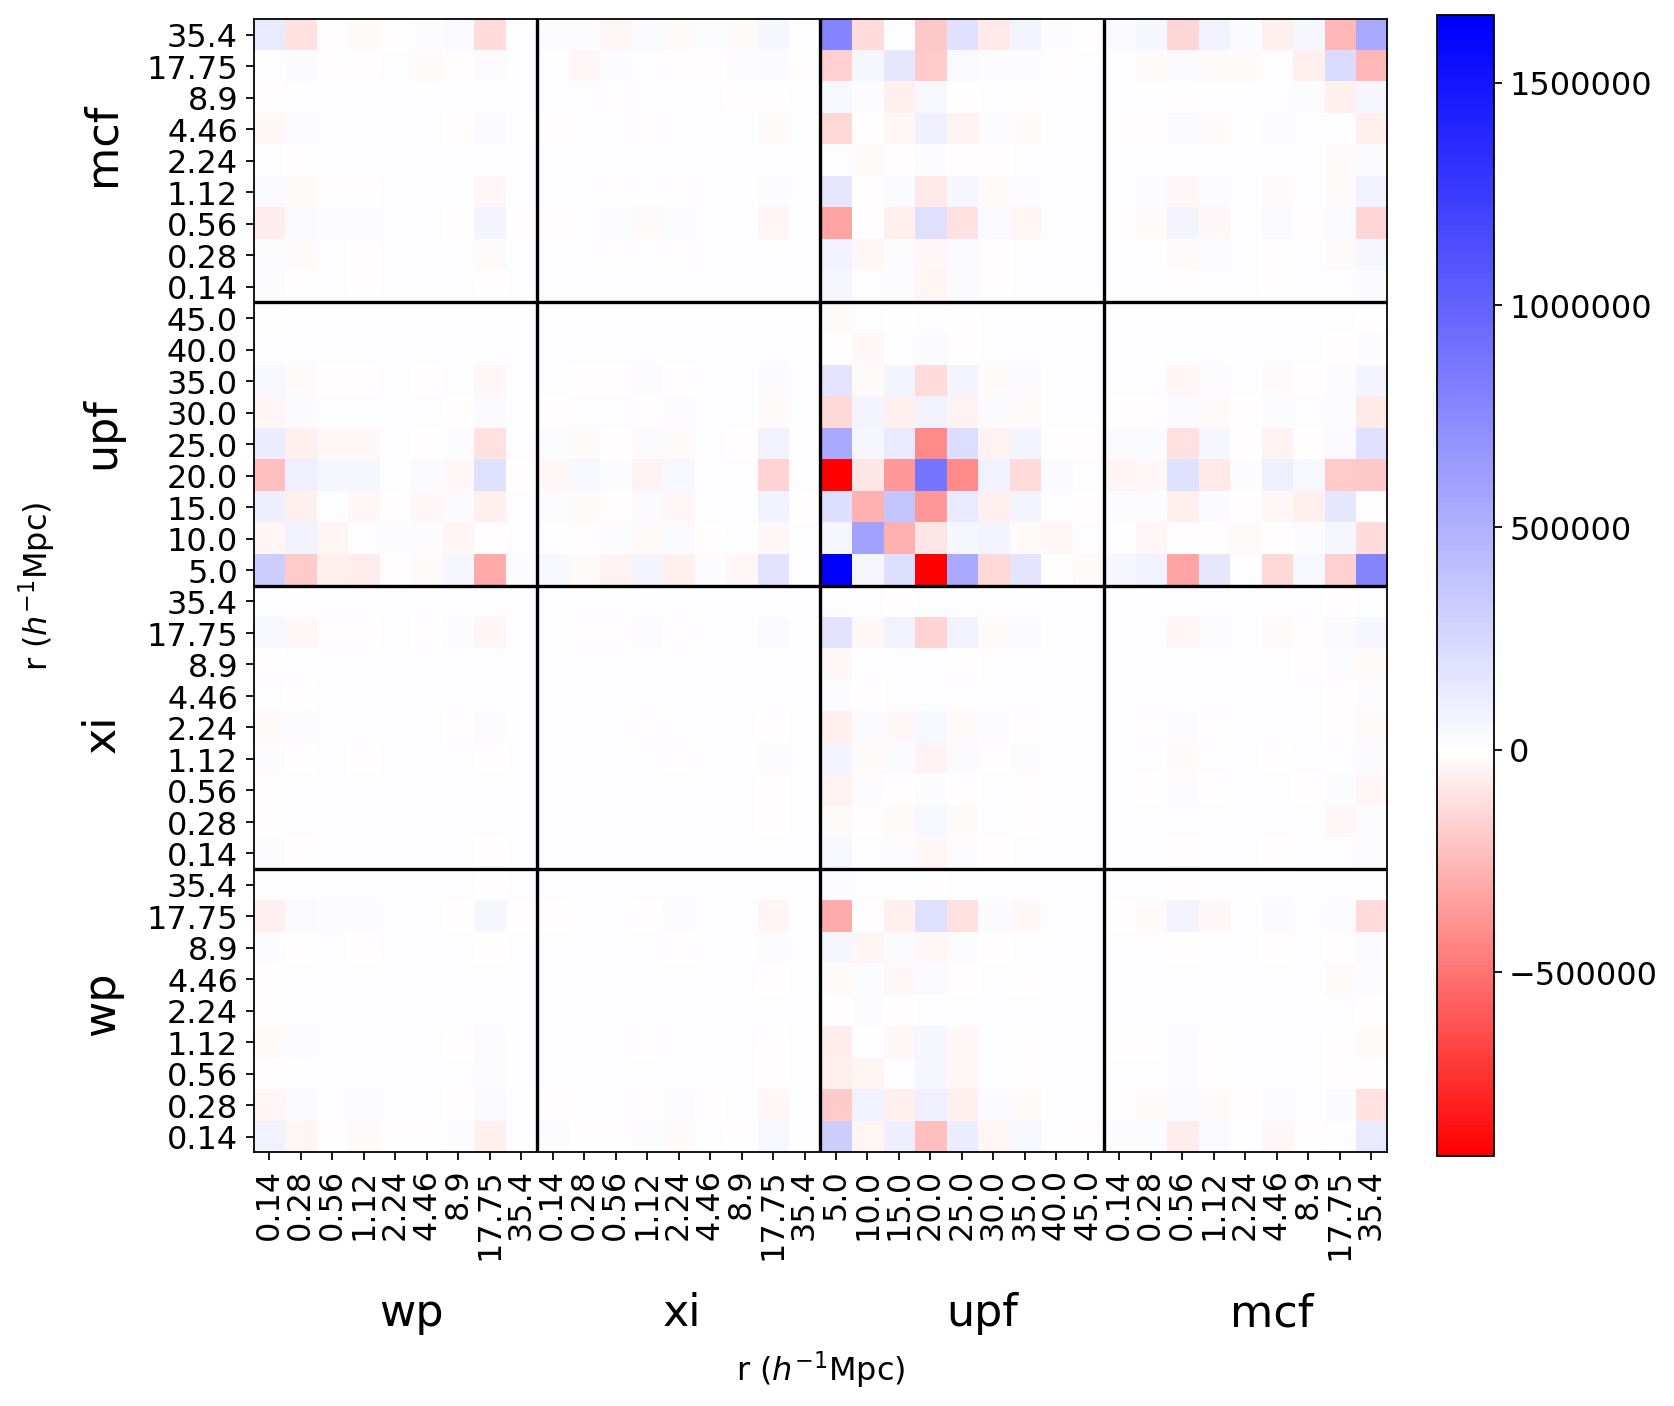

In [35]:
icov_emu_largest = eigendecomp_v2(icov_emu, 3)
plot_icov_matrix(icov_emu_largest, statistics_all)

## emu wp

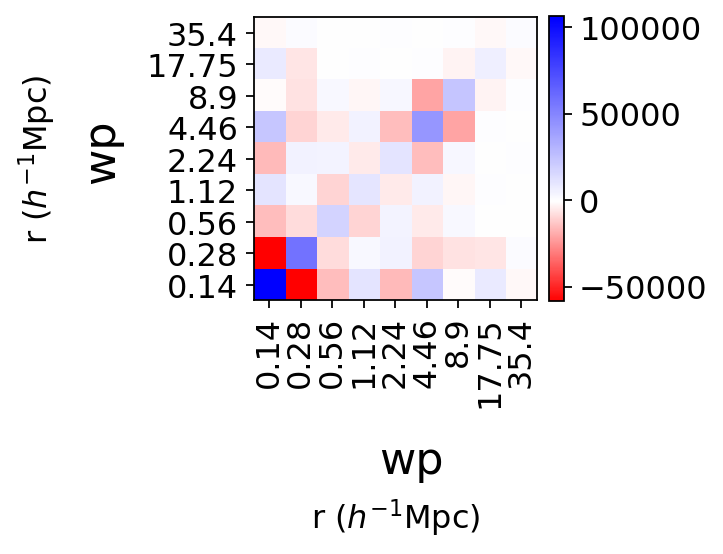

In [277]:
cov_emuperf_w = get_cov(['wp'], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
cov_glam_w = get_cov(['wp'], 'glam')
cov_glam_scaled_w = cov_glam_w*(1/5)*(L_glam/L_aemulus)**3
cov_emu_w = cov_emuperf_w - cov_glam_scaled_w

icov_emu_w = np.linalg.inv(cov_emu_w)
plot_icov_matrix(icov_emu_w, ['wp'])

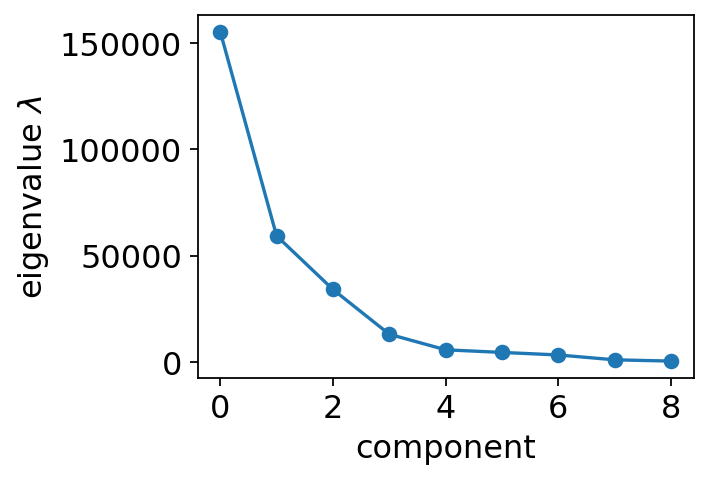

In [278]:
plot_eigenvalues(icov_emu_w)

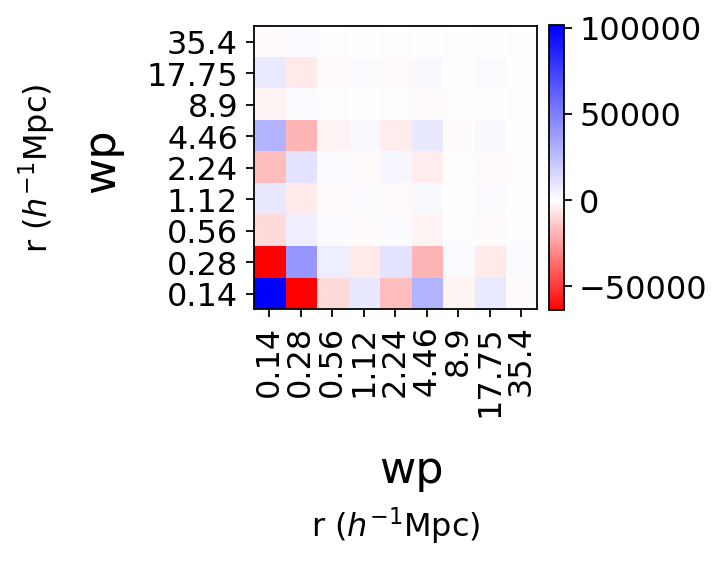

In [279]:
icov_emu_w_largest = eigendecomp_v2(icov_emu_w, 1)
plot_icov_matrix(icov_emu_w_largest, ['wp'])

## SVD on correlation matrix (via zhongxu)

In [18]:
corr = utils.reduced_covariance(cov_glam)
Nmock = 986 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov_glam_svd = np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix

[34 35]


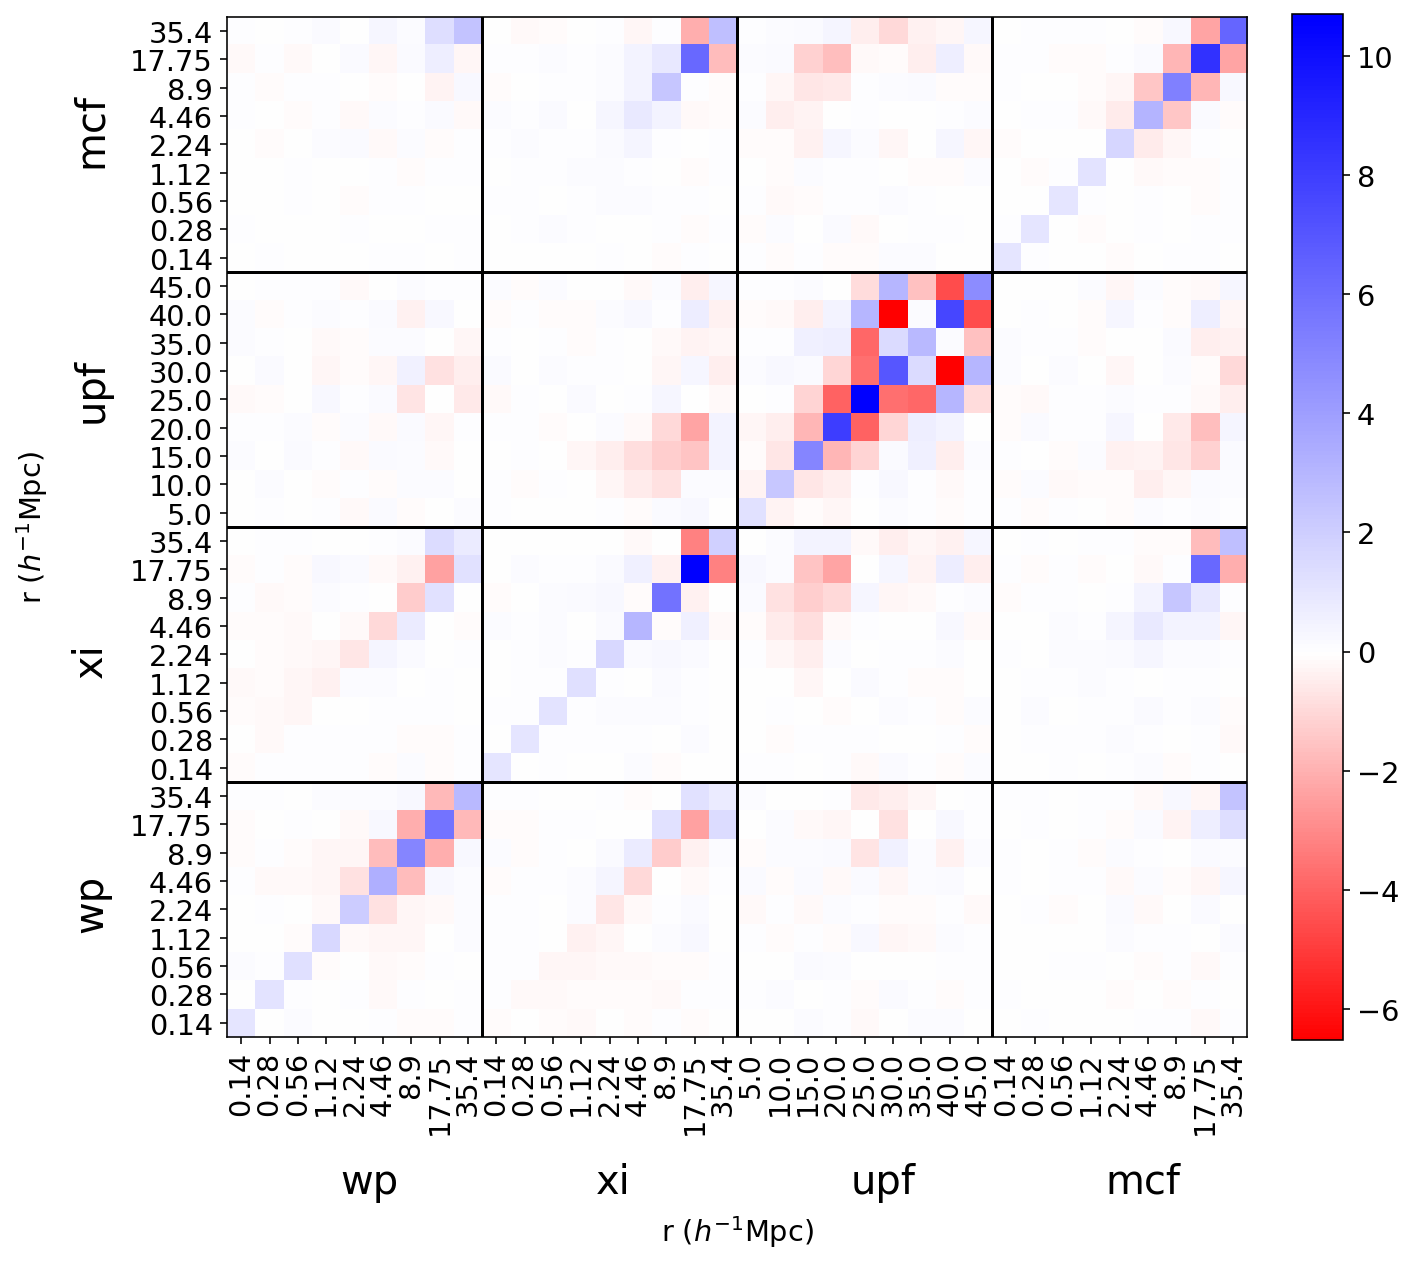

In [19]:
plot_icov_matrix(icov_glam_svd, statistics_all)

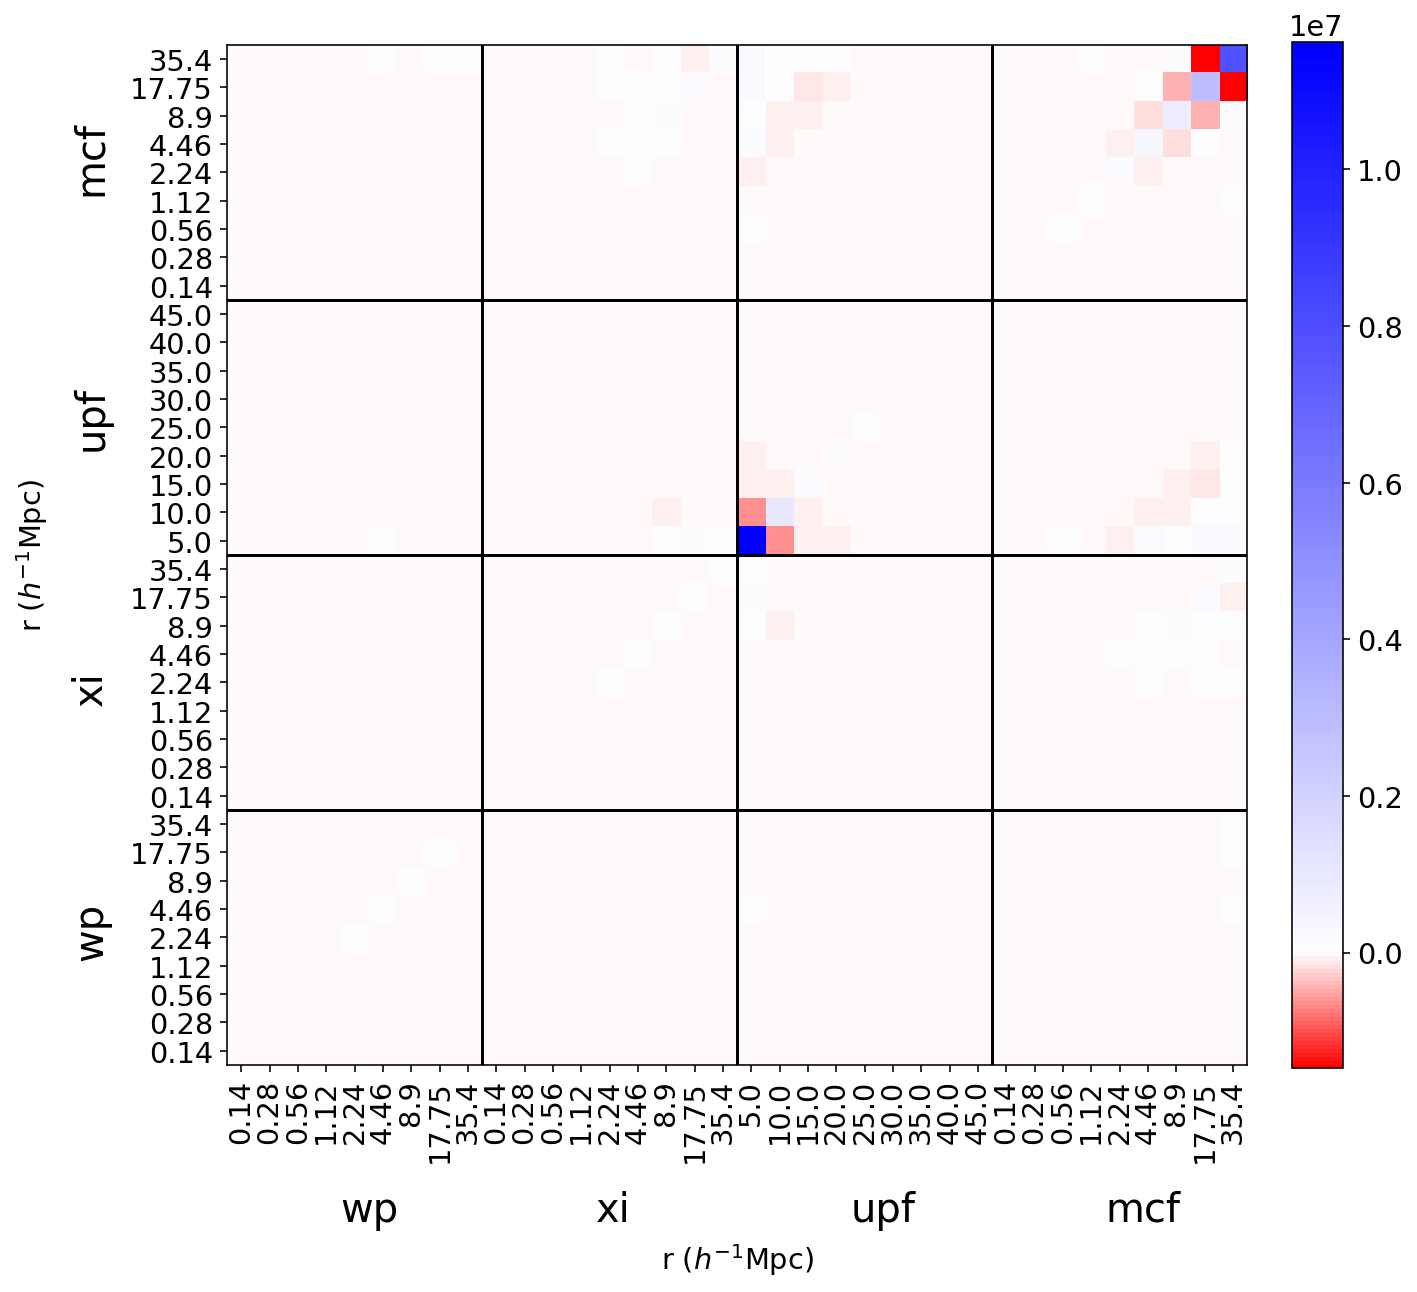

In [20]:
plot_icov_matrix(np.linalg.inv(cov_glam), statistics_all)

In [25]:
corr = utils.reduced_covariance(cov_aemulus)
Nmock = 35 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov_glam_aemulus = np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


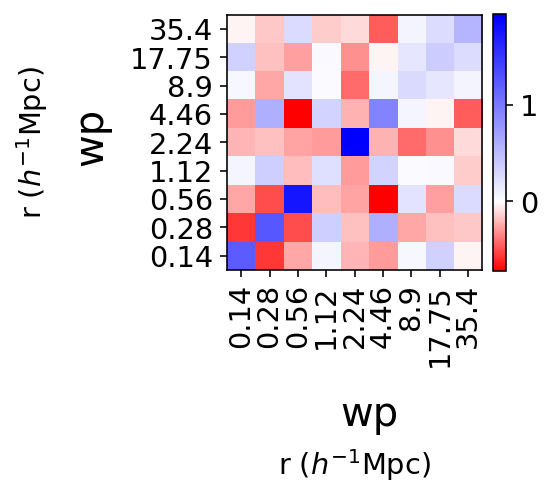

In [32]:
plot_icov_matrix(icov_glam_aemulus_w, ['wp'])

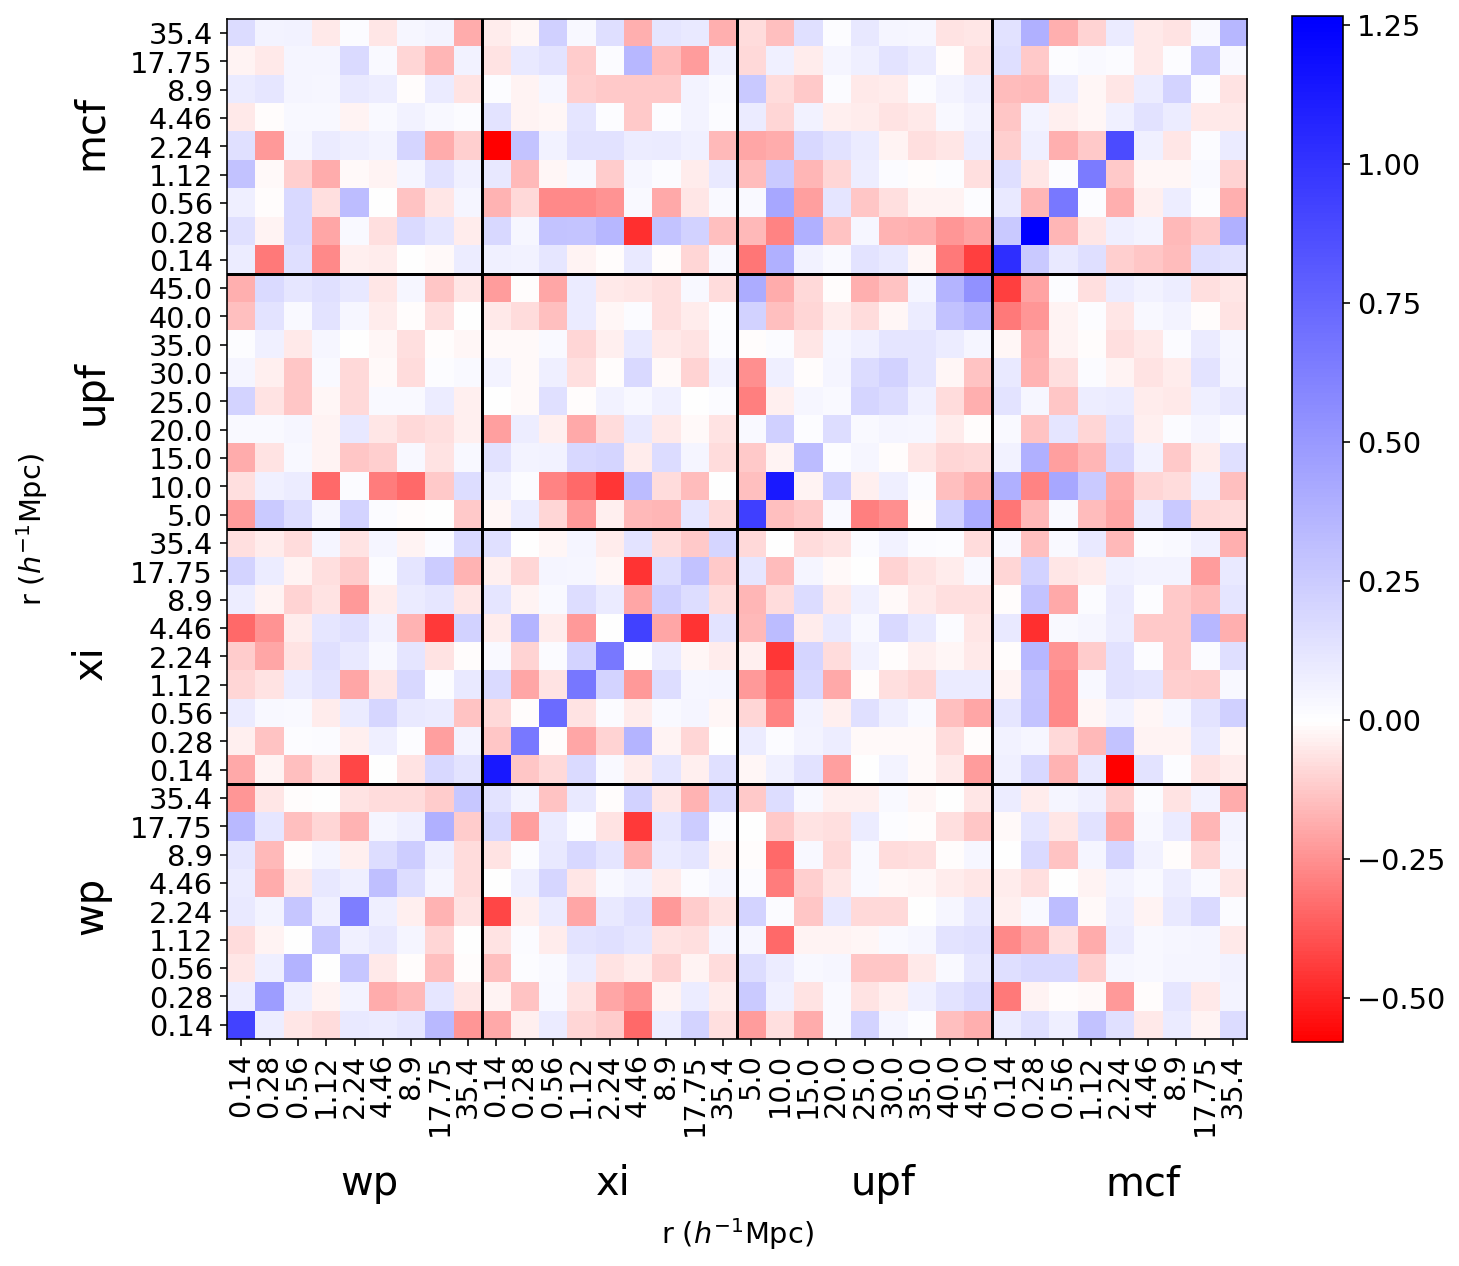

In [26]:
plot_icov_matrix(icov_glam_aemulus, statistics_all)

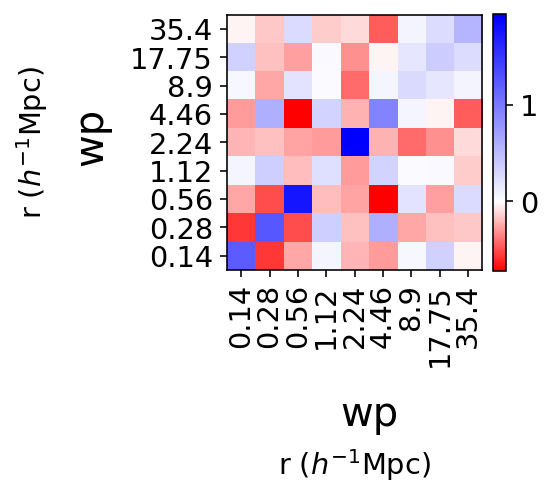

In [33]:
plot_icov_matrix(icov_glam_aemulus_w, ['wp'])

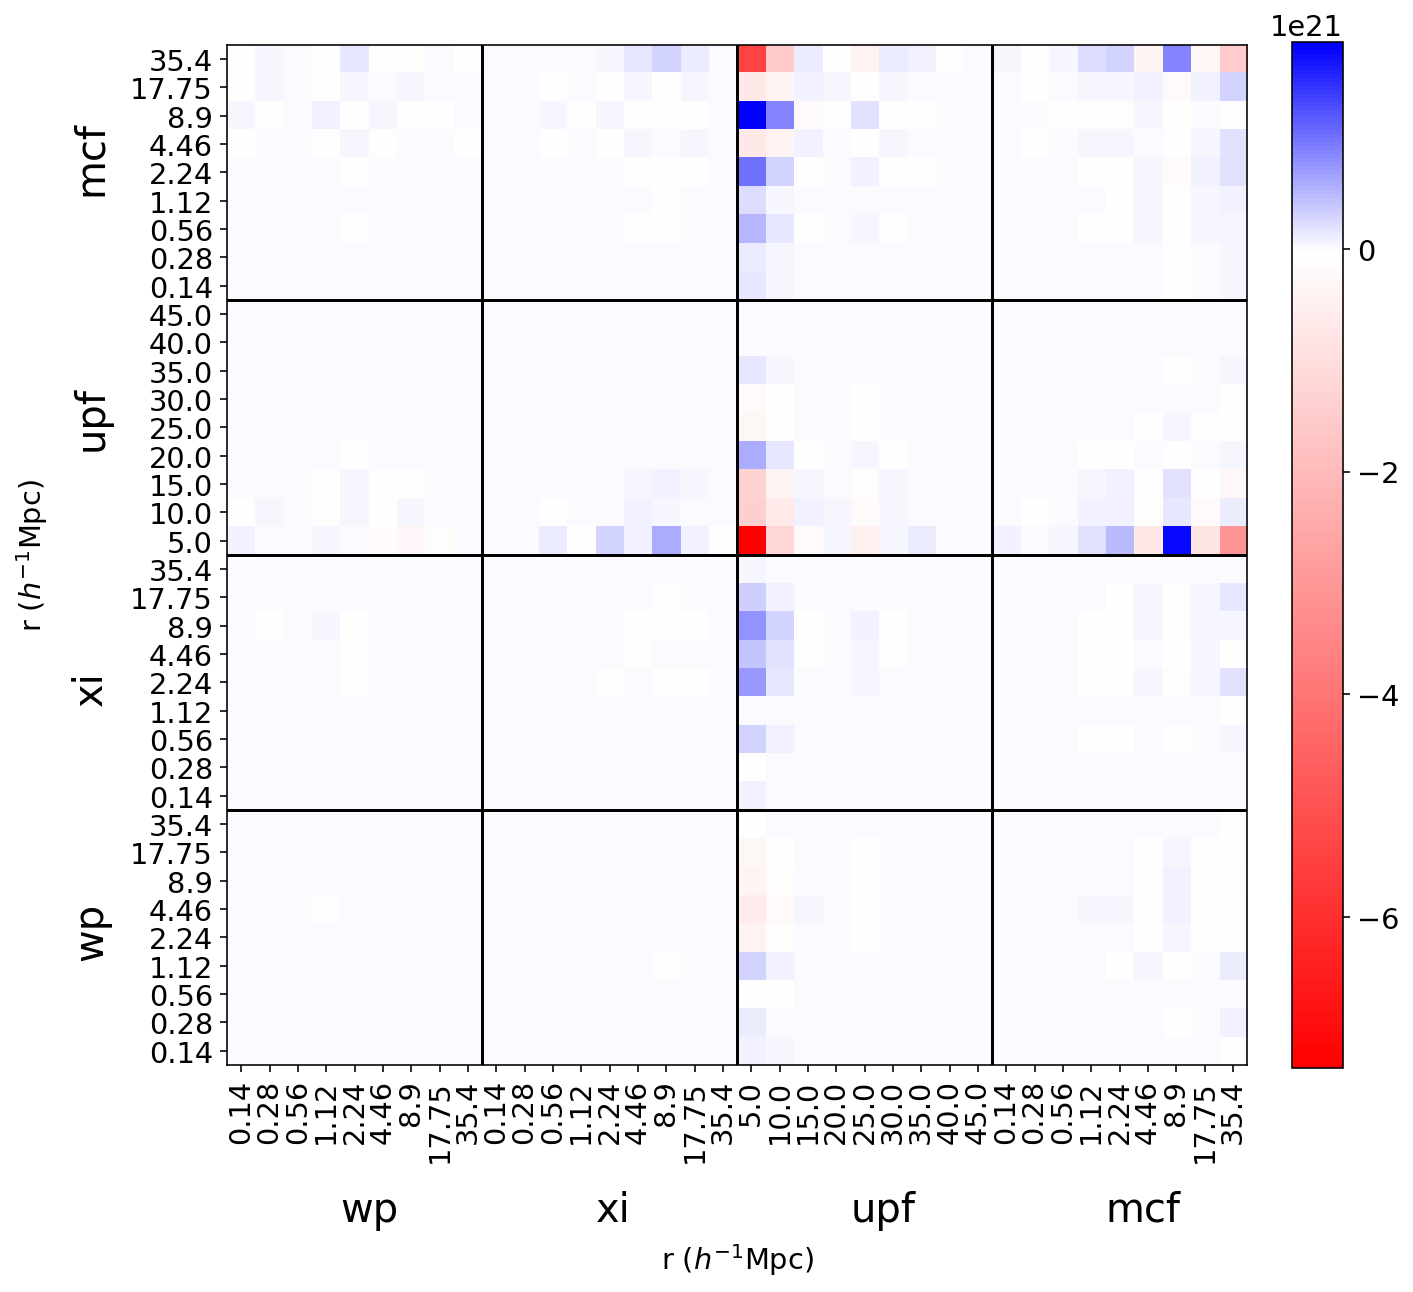

In [27]:
plot_icov_matrix(np.linalg.inv(cov_aemulus), statistics_all)

In [28]:
cov_aemulus_w = get_cov(['wp'], 'aemulus', tag_str='_hod3_test0')

In [29]:
corr = utils.reduced_covariance(cov_aemulus_w)
Nmock = 35 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov_glam_aemulus_w = np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix

[6 7 8]


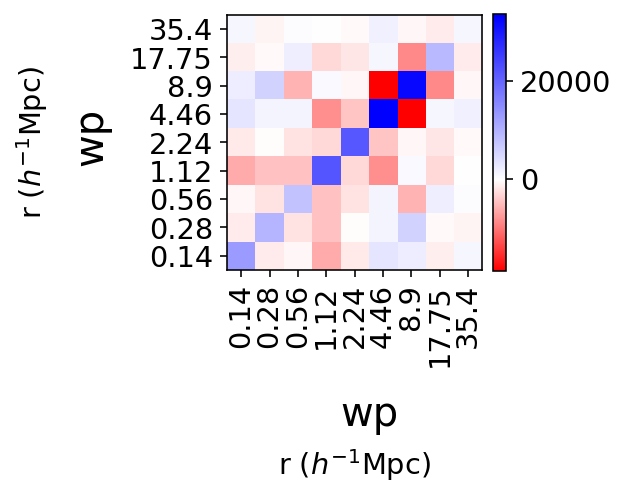

In [30]:
plot_icov_matrix(np.linalg.inv(cov_aemulus_w), ['wp'])

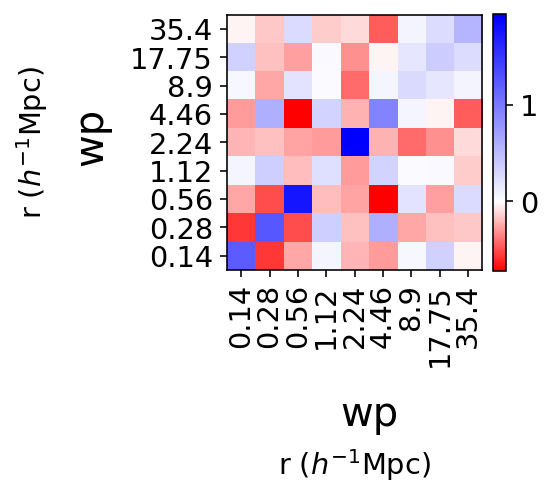

In [31]:
plot_icov_matrix(icov_glam_aemulus_w, ['wp'])

### test likelihood

In [15]:
hods_test = np.loadtxt("/mount/sirocco2/zz681/emulator/CMASSLOWZ/test_galaxy_mocks_wp_RSD/test_galaxy_mocks_new_f_env/HOD_test_np11_n1000_new_f_env.dat")
nhodparams_test = hods_test.shape[1]
hods_test[:,0] = np.log10(hods_test[:,0])
hods_test[:,2] = np.log10(hods_test[:,2])
cosmos_test = np.loadtxt("../CMASS/Gaussian_Process/hod_file/cosmology_camb_test_box_full.dat")
ncosmoparams_test = cosmos_test.shape[1]
cosmo_names = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_names = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']

In [12]:
cosmo, hod = 3, 3

In [13]:
cosmo_params = cosmos_test[cosmo]
hod_params = hods_test[hod]

In [17]:
params = np.concatenate((cosmo_params, hod_params))

In [18]:
params

array([ 0.289014  ,  0.0434999 ,  0.859613  ,  0.707317  ,  0.953515  ,
        3.7       , -1.13151   , 14.27600935,  1.438172  , 12.41536871,
        0.2861269 ,  0.5629193 ,  0.6943786 ,  1.906767  ,  0.5601679 ,
       -0.1069814 ,  1.687248  ,  0.8692401 ])

In [19]:
def lnlike_icov(theta, param_names, fixed_params, ys, icov):
    s = time.time()
    theta = np.array(theta).flatten() #theta looks like [[[p]]] for some reason
    param_dict = dict(zip(param_names, theta)) #weirdly necessary for Powell minimization
    param_dict.update(fixed_params)
    emu_preds = []
    for emu in _emus:
        pred = emu.predict(param_dict)
        emu_preds.append(pred)

    emu_pred = np.hstack(emu_preds)
    diff = (np.array(emu_pred) - np.array(ys))/np.array(ys) #fractional error
    diff = diff.flatten()

    like = -0.5 * np.dot(diff, np.dot(icov, diff))
    e = time.time()
    print("like call: theta=", theta, "; time=", e-s, "s; like =", like)

    return like

In [ ]:
param_names = []
theta = []
fixed_params = params
y = np.loadtxt(testing_dirs[i]+'{}_cosmo_{}_HOD_{}_mean.dat'.format(statistic, cosmo, hod))

-7218.322775117848 15741.144592692279


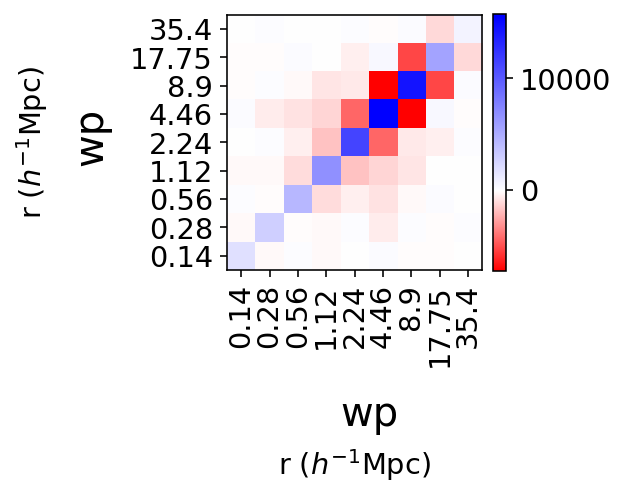

In [24]:
chaintag = 'wp_c3h3_omegam_dy_glamicov'
chain_fn = f'../chains/chains_{chaintag}.h5'
cov_dir = '../../clust/covariances/'
with h5py.File(chain_fn, 'r+') as f:

    statistics = f.attrs['statistic']
    traintags = f.attrs['traintag']
    testtags = f.attrs['testtag']
    errtags = f.attrs['errtag']
    stat_str = '_'.join(statistics)
    
    icov_fn = f.attrs['icov_fn']
    icov = np.loadtxt(icov_fn)
    print(min(icov.flatten()), max(icov.flatten()))
    plot_icov_matrix(icov, statistics)

-2.297797273694358 4.047711360589537


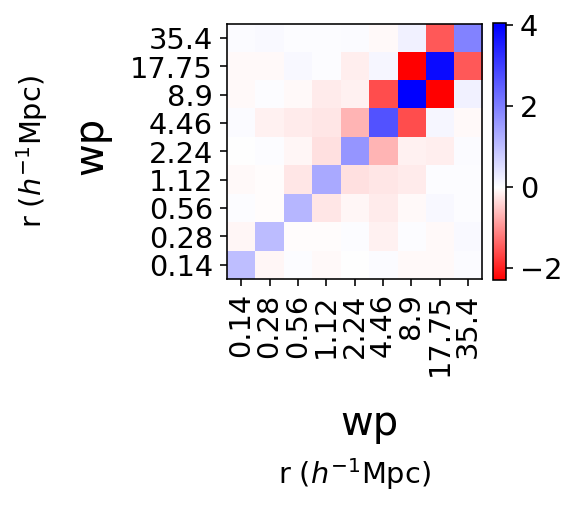

In [25]:
chaintag = 'wp_c3h3_omegam_dy_glamicovsvd'
chain_fn = f'../chains/chains_{chaintag}.h5'
cov_dir = '../../clust/covariances/'
with h5py.File(chain_fn, 'r+') as f:

    statistics = f.attrs['statistic']
    traintags = f.attrs['traintag']
    testtags = f.attrs['testtag']
    errtags = f.attrs['errtag']
    stat_str = '_'.join(statistics)
    
    icov_fn = f.attrs['icov_fn']
    icov = np.loadtxt(icov_fn)
    print(min(icov.flatten()), max(icov.flatten()))
    plot_icov_matrix(icov, statistics)

-4.479325718829832e-06 0.0029712054524922826


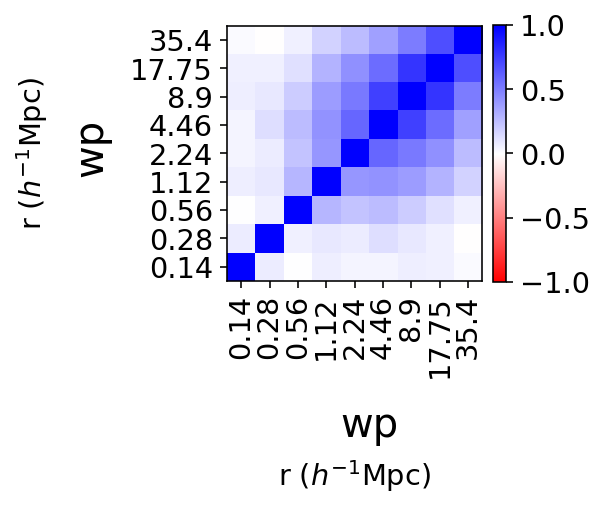

In [27]:
chaintag = 'wp_c3h3_omegam_dy_glamcov'
chain_fn = f'../chains/chains_{chaintag}.h5'
cov_dir = '../../clust/covariances/'
with h5py.File(chain_fn, 'r+') as f:

    statistics = f.attrs['statistic']
    traintags = f.attrs['traintag']
    testtags = f.attrs['testtag']
    errtags = f.attrs['errtag']
    stat_str = '_'.join(statistics)
    
    cov_fn = f.attrs['cov_fn']
    cov = np.loadtxt(cov_fn)
    print(min(cov.flatten()), max(cov.flatten()))
    corr = utils.reduced_covariance(cov)
    plot_correlation_matrix(corr, statistics)

In [30]:
cov = get_cov(['wp'], 'glam', tag_str='')
corr = utils.reduced_covariance(cov)
Nmock = 986 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov= np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix

[]


[]


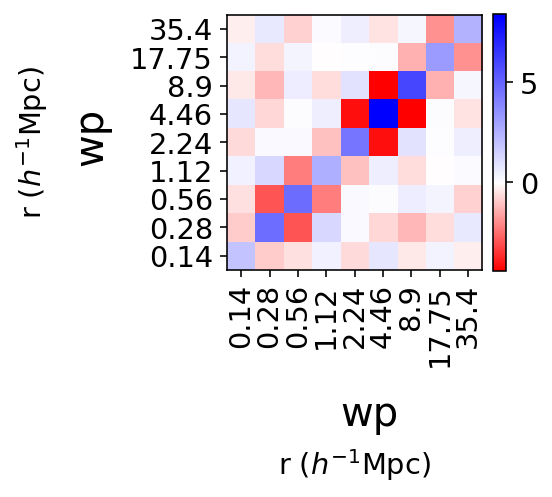

In [11]:
statistics = ['wp']
cov = get_cov(statistics, 'emuaem', tag_str='')
corr = utils.reduced_covariance(cov)
Nmock = 700 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov= np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix
plot_icov_matrix(icov, statistics)

[30 31 32 33 34 35]


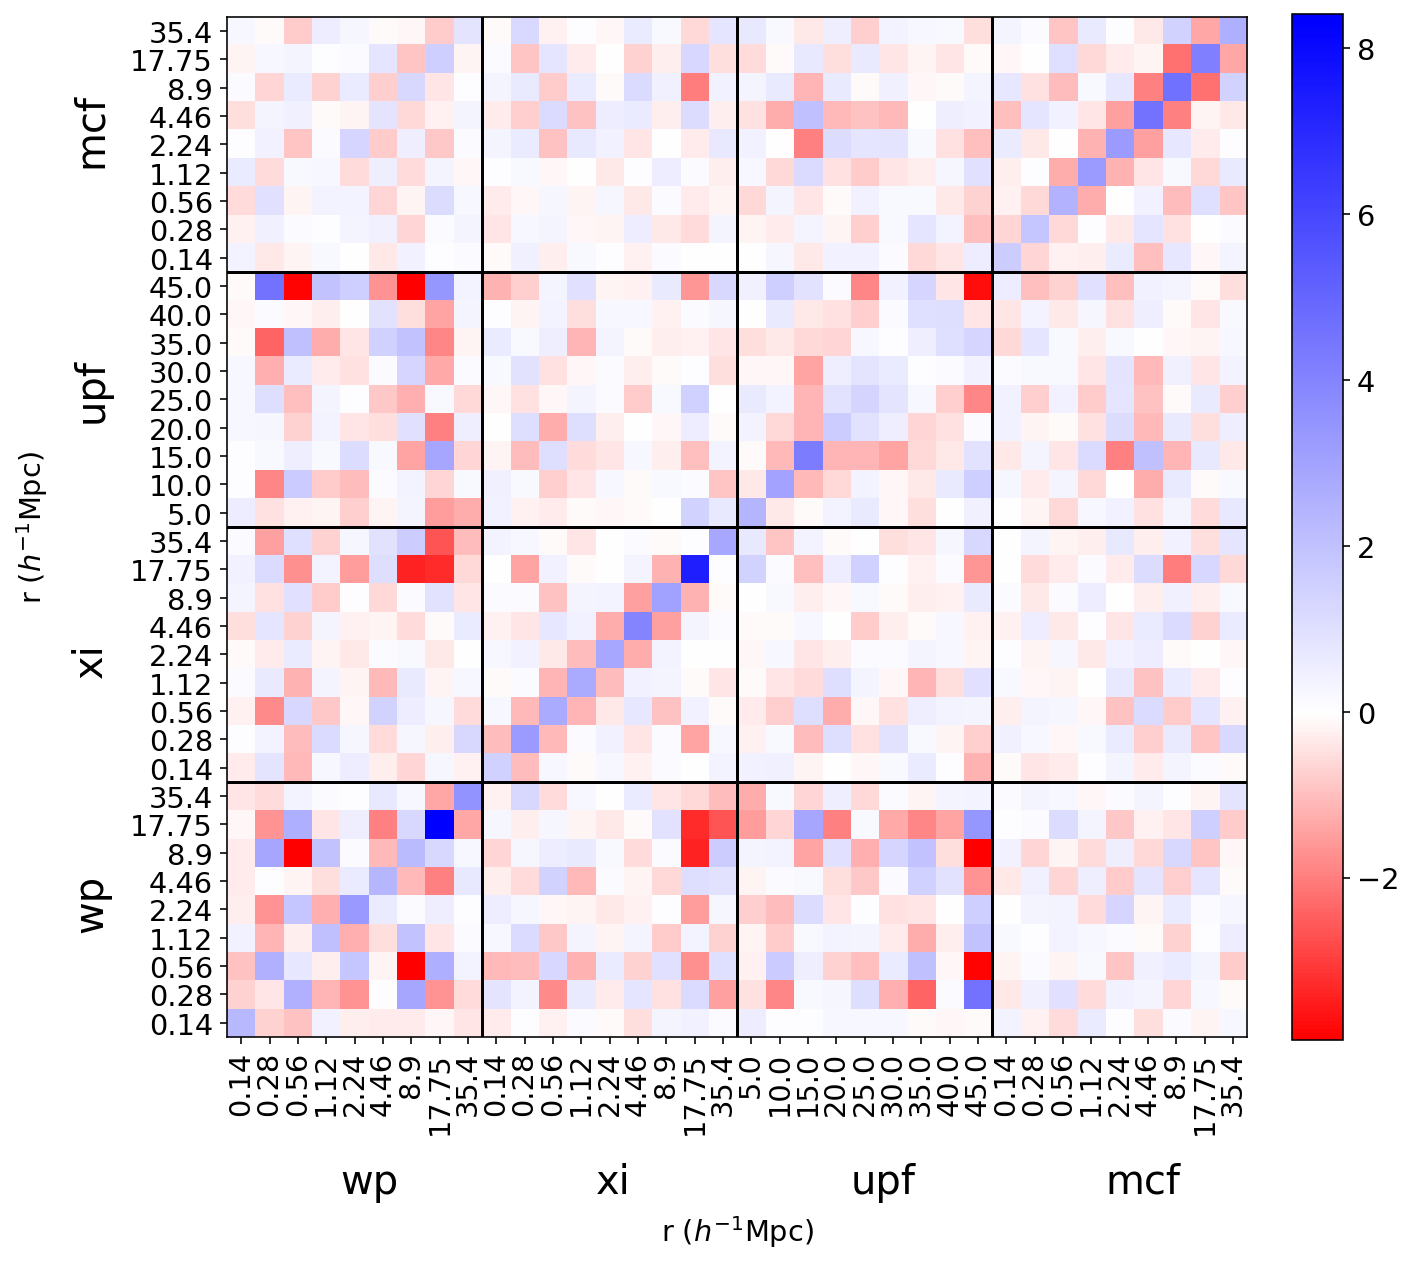

In [12]:
#statistics = ['wp']
statistics = statistics_all
cov = get_cov(statistics, 'emuaem', tag_str='')
corr = utils.reduced_covariance(cov)
Nmock = 700 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov= np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix
plot_icov_matrix(icov, statistics)

[]


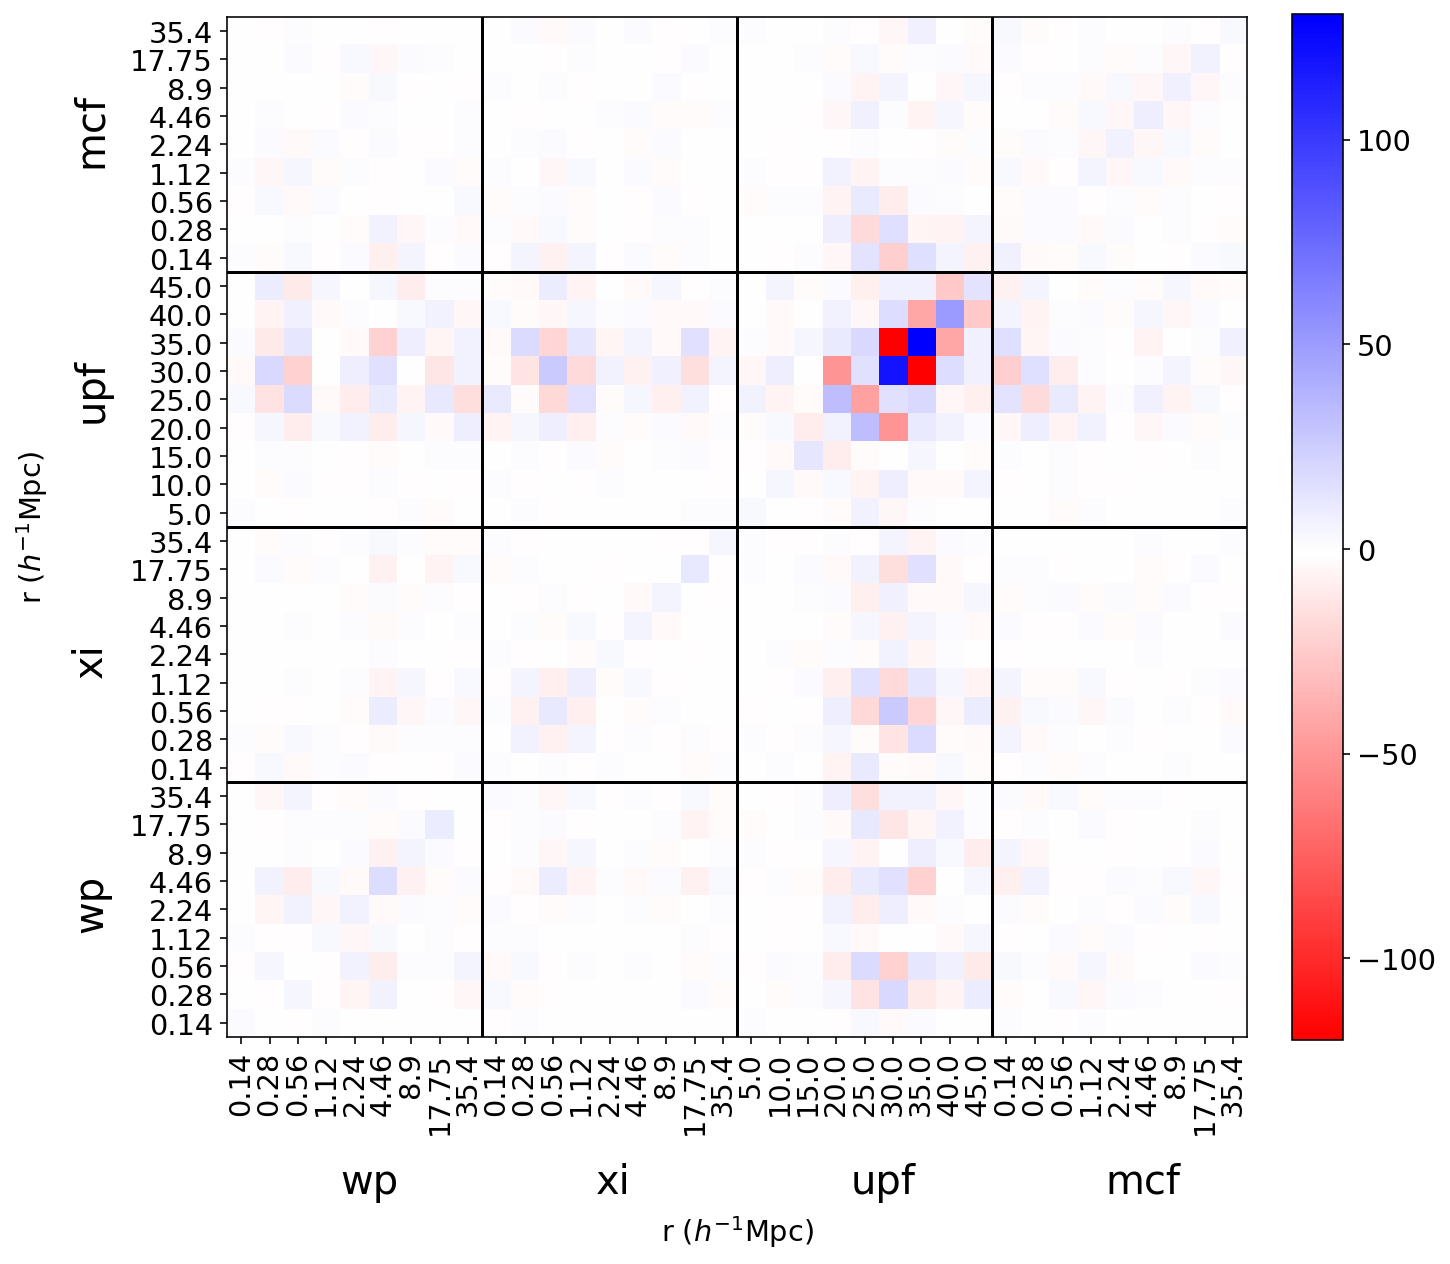

In [13]:
#statistics = ['wp']
statistics = statistics_all
cov = get_cov(statistics, 'emuaem', tag_str='')
corr = utils.reduced_covariance(cov)
Nmock = 700 # number of mocks (if you are using GLAM)
u1, s1, vh1 = np.linalg.svd(corr)
v1 = vh1.T
#ids_small = np.where(s1<np.sqrt(2./Nmock))[0] # Eq (20) of https://arxiv.org/pdf/astro-ph/0501637.pdf
ids_small = []
print(ids_small)
s1_inv = 1./s1
s1_inv[ids_small] = 0.0
s1_new = np.diag(s1_inv)
icov= np.dot(v1, np.dot(s1_new, u1.T)) # inverse matrix
plot_icov_matrix(icov, statistics)

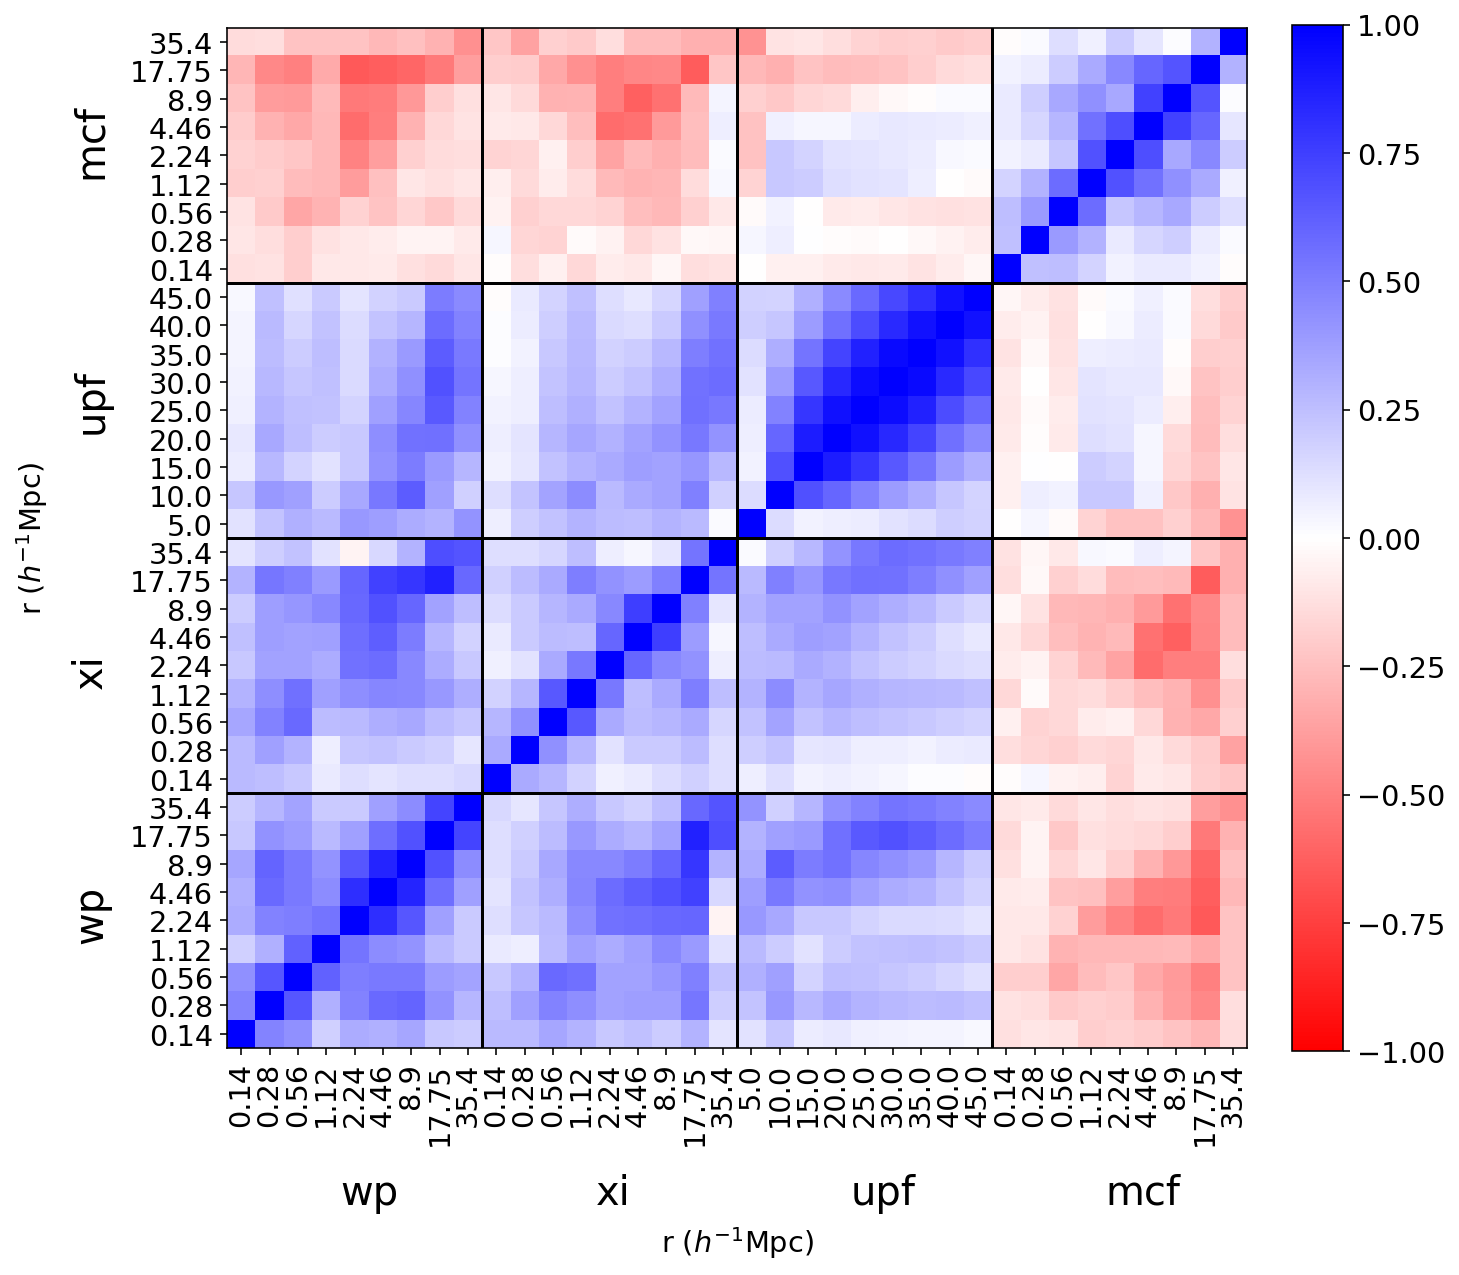

In [11]:
cov_final = get_cov(statistics_all, 'final', tag_str='')
corr_final = utils.reduced_covariance(cov_final)
plot_correlation_matrix(corr_final, statistics_all)

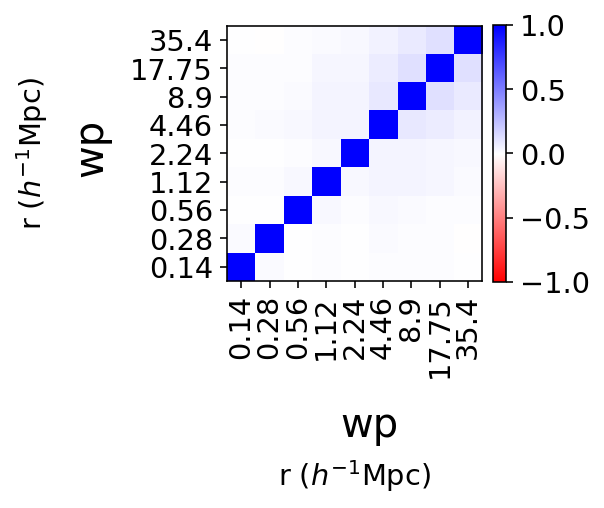

In [13]:
cov_final = get_cov(['wp'], 'glamemudiag', tag_str='')
corr_final = utils.reduced_covariance(cov_final)
plot_correlation_matrix(corr_final, ['wp'])

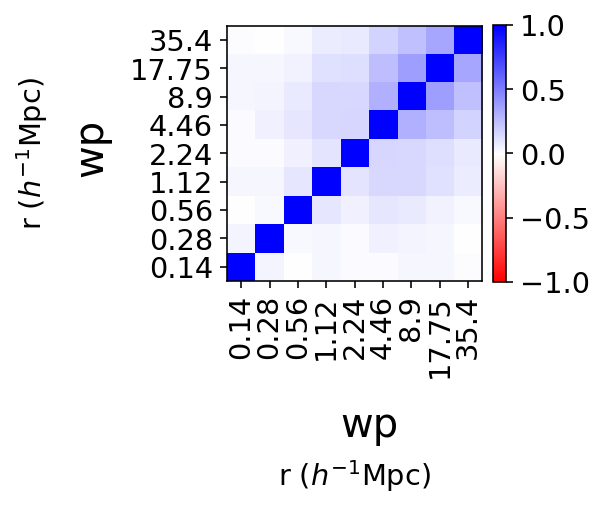

In [14]:
cov_final = get_cov(['wp'], 'glamemudiagnoB', tag_str='')
corr_final = utils.reduced_covariance(cov_final)
plot_correlation_matrix(corr_final, ['wp'])

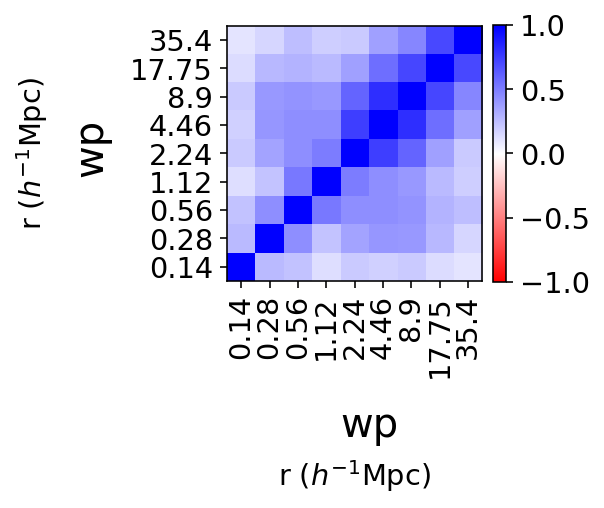

In [15]:
cov_final = get_cov(['wp'], 'glamemunoB', tag_str='')
corr_final = utils.reduced_covariance(cov_final)
plot_correlation_matrix(corr_final, ['wp'])

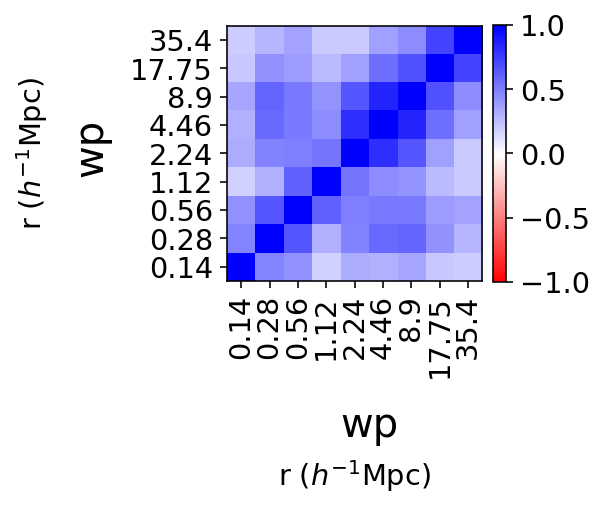

In [16]:
cov_final = get_cov(['wp'], 'final', tag_str='')
corr_final = utils.reduced_covariance(cov_final)
plot_correlation_matrix(corr_final, ['wp'])

## Compare ksf & zhongxu emu errors

In [46]:
nbins = 9
redges_z = np.logspace(-1, 1.78, nbins+1)
rbins_z = 10**(0.5*(np.log10(redges_z)[:-1] + np.log10(redges_z)[1:]))
redges_k = np.logspace(np.log10(0.1), np.log10(50), nbins+1)
rbins_k = 10**(0.5*(np.log10(redges_k)[:-1] + np.log10(redges_k)[1:]))

In [47]:
#err_fn_z = '/mount/sirocco2/zz681/emulator/CMASSLOWZ_Msat/emulator_error.dat'
err_fn_z = '/mount/sirocco2/zz681/emulator/CMASSLOWZ_Msat/emulator_error_fractional.dat'
err_z = np.loadtxt(err_fn_z)
err_z = err_z.reshape((-1, nbins))
print(err_z.shape)

(3, 9)


In [50]:
err_k = np.empty(err_z.shape)
# percentile 
cov_dir = '/home/users/ksf293/clust/covariances'
save_fn_err68_emuaem_wp = f"{cov_dir}/err68_emuaem_wp.dat"
save_fn_err68_emuaem_xi = f"{cov_dir}/err68_emuaem_xi.dat"
err_k[0,:] = np.loadtxt(save_fn_err68_emuaem_wp)
err_k[1,:] = np.loadtxt(save_fn_err68_emuaem_xi)
# stdev 
# cov_emu_wp = get_cov(['wp'], 'emuaem', tag_str='')
# cov_emu_xi = get_cov(['xi'], 'emuaem', tag_str='')
#err_k[0, :] = np.sqrt(np.diag(cov_emu_wp))
#err_k[1, :] = np.sqrt(np.diag(cov_emu_xi))

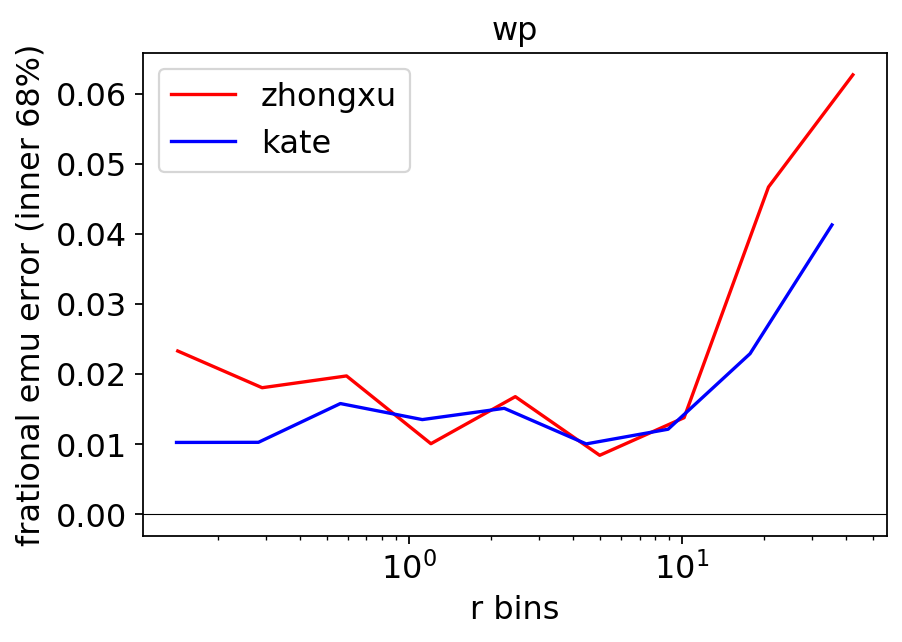

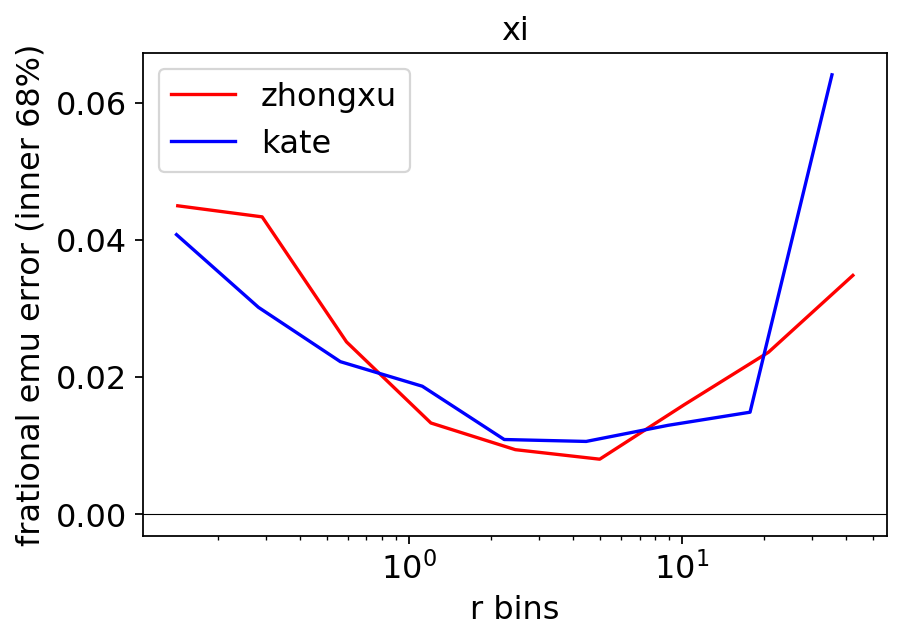

In [52]:
statistics = ['wp', 'xi']
for i, statistic in enumerate(statistics):
    plt.figure()
    plt.title(statistic)
    plt.plot(rbins_z, err_z[i], label='zhongxu', color='red')
    plt.plot(rbins_k, err_k[i], label='kate', color='blue')
    plt.xlabel('r bins')
    plt.ylabel(f'frational emu error (inner 68%)')
    plt.xscale('log')
    plt.legend()
    plt.axhline(0, color='k', lw=0.5)

## Compare predictions on mean vs individual 

In [24]:
def get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=None):
    assert "mean" in acctag or boxes is not None, "need either mean or boxes!"
    err_dict = {}
    abserrs = []
    fracerrs = []
    ptests = []
    for cosmo in CC_test:
        for hod in HH_test:
            idtags = []
            meantag = '{}_cosmo_{}_HOD_{}_mean'.format(statistic, cosmo, hod)
            if "mean" in testtag:
                idtags.append(meantag)
            else:
                for box in boxes:
                    idtags.append('{}_cosmo_{}_Box_{}_HOD_{}_test_0'.format(statistic, cosmo, box, hod))
                    
            for idtag in idtags:
                #TEST
                fnt = '{}testing_{}{}/{}.dat'.format(res_dir, statistic, testtag, idtag)
                try:
                    rtest, ptest = np.loadtxt(fnt)#, delimiter=',', unpack=True)
                except:
                    rtest, ptest = np.loadtxt(fnt, delimiter=',', unpack=True)
                # PREDICT
                fnp = '../testing_results/predictions_{}{}/{}.dat'.format(statistic, acctag, meantag)
                rpredic, ppredic = np.loadtxt(fnp, delimiter=',', unpack=True)

                ptests.append(ptest)

                fracerr = (ppredic-ptest)/ptest
                fracerrs.append(fracerr)
                err_dict[(cosmo, hod)] = fracerr

                abserr = ppredic-ptest
                abserrs.append(abserr)
    return rtest, fracerrs, abserrs, err_dict

In [25]:
statistic = 'xi'
traintag = '_nonolap'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst2'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctesttag = '_mean_test0'
acctag = gptag + acctesttag + savetag

res_dir = '../../clust/results_{}/'.format(statistic)
CC_test = range(0, 7)
HH_test = range(0, 100)

# mean
testtag = '_mean_test0'
rtest, fracerrs_mean, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=None)

# each of 5
testtag = ''
boxes = range(0, 5)
rtest, fracerrs_5boxes, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=boxes)

# 5 individual
testtag = ''
boxes = range(0, 5)
fracerrs_boxis = []
for box in boxes:
    boxes = [box]
    
    rtest, fracerrs_boxi, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=boxes)
    fracerrs_boxis.append(fracerrs_boxi)

In [26]:
std_mean = np.std(fracerrs_mean, axis=0)
std_5boxes = np.std(fracerrs_5boxes, axis=0)
std_boxis = []
for fracerrs_boxi in fracerrs_boxis:
    std_boxis.append(np.std(fracerrs_boxi, axis=0))

In [27]:
cov_dir = "../../clust/covariances/"
stat_str = statistic
err_str = errtag
cov_aem = np.loadtxt(cov_dir+"cov_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))
err_1box = np.sqrt(np.diag(cov_aem))
err_5box = np.sqrt(1./5.)*err_1box
#gpp16 = np.loadtxt(cov_dir+"p16_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))
#gpp84 = np.loadtxt(cov_dir+"p84_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))

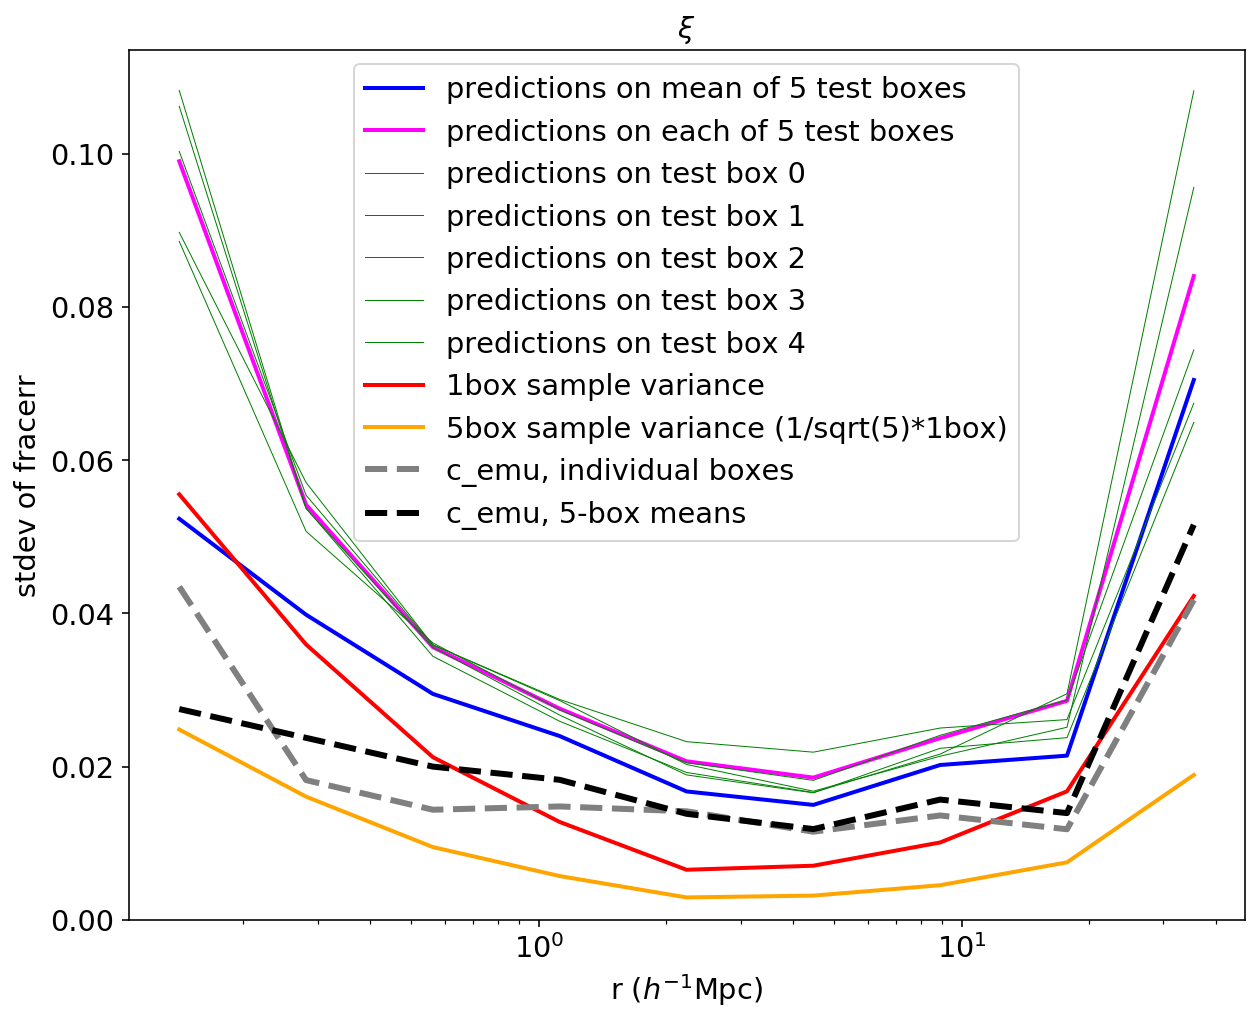

In [28]:
plt.figure(figsize=(10,8))
plt.plot(rtest, std_mean, label="predictions on mean of 5 test boxes", color='blue', lw=2)
plt.plot(rtest, std_5boxes, label="predictions on each of 5 test boxes", color='magenta', lw=2)
for i,std_boxi in enumerate(std_boxis):
    plt.plot(rtest, std_boxi, label=f"predictions on test box {i}", color='green', lw=0.5)
    
plt.plot(rtest, err_1box, label="1box sample variance", color='red', lw=2)
plt.plot(rtest, err_5box, label="5box sample variance (1/sqrt(5)*1box)", color='orange', lw=2)    
    
plt.plot(rtest, std_5boxes - err_1box, label="c_emu, individual boxes", color='grey', lw=3, ls='--')
plt.plot(rtest, std_mean - err_5box, label="c_emu, 5-box means", color='black', lw=3, ls='--')  

plt.title(r"$\xi$")
plt.xscale("log")
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r"stdev of fracerr")
plt.ylim(0)
plt.legend()

In [17]:
statistic = 'wp'
traintag = '_nonolap'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst2'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctesttag = '_mean_test0'
acctag = gptag + acctesttag + savetag

res_dir = '../../clust/results_{}/'.format(statistic)
CC_test = range(0, 7)
HH_test = range(0, 100)

# mean
testtag = '_mean_test0'
rtest, fracerrs_mean, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=None)

# each of 5
testtag = ''
boxes = range(0, 5)
rtest, fracerrs_5boxes, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=boxes)

# 5 individual
testtag = ''
boxes = range(0, 5)
fracerrs_boxis = []
for box in boxes:
    boxes = [box]
    
    rtest, fracerrs_boxi, _, _ = get_errors(statistic, res_dir, testtag, CC_test, HH_test, boxes=boxes)
    fracerrs_boxis.append(fracerrs_boxi)

In [18]:
std_mean = np.std(fracerrs_mean, axis=0)
std_5boxes = np.std(fracerrs_5boxes, axis=0)
std_boxis = []
for fracerrs_boxi in fracerrs_boxis:
    std_boxis.append(np.std(fracerrs_boxi, axis=0))

In [19]:
cov_dir = "../../clust/covariances/"
stat_str = statistic
err_str = errtag
cov_aem = np.loadtxt(cov_dir+"cov_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))
err_1box = np.sqrt(np.diag(cov_aem))
err_5box = np.sqrt(1./5.)*err_1box
#gpp16 = np.loadtxt(cov_dir+"p16_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))
#gpp84 = np.loadtxt(cov_dir+"p84_aemulus_{}{}{}.dat".format(stat_str, err_str, savetag))

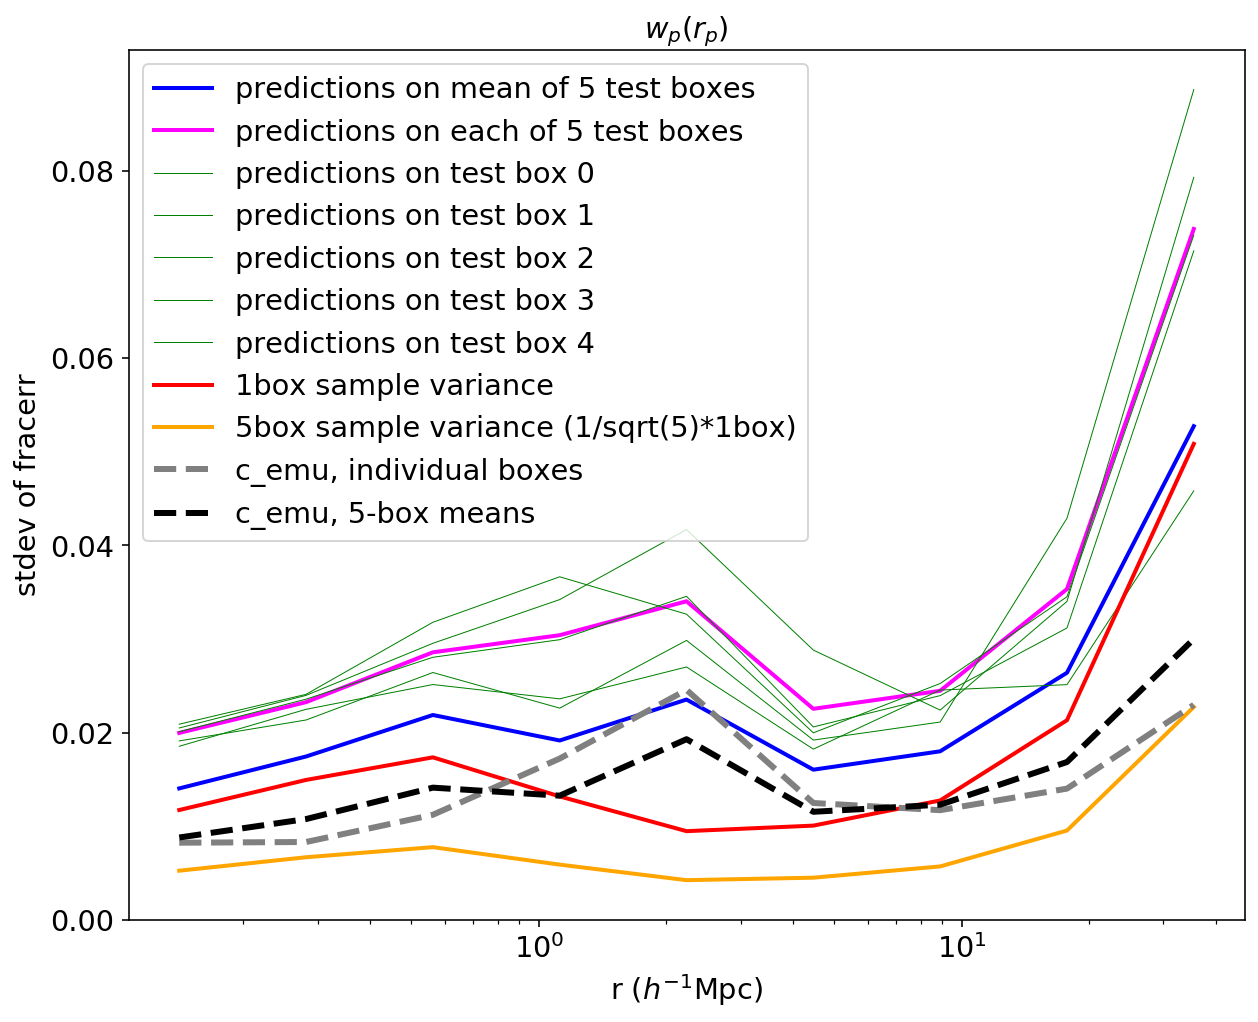

In [23]:
plt.figure(figsize=(10,8))
plt.plot(rtest, std_mean, label="predictions on mean of 5 test boxes", color='blue', lw=2)
plt.plot(rtest, std_5boxes, label="predictions on each of 5 test boxes", color='magenta', lw=2)
for i,std_boxi in enumerate(std_boxis):
    plt.plot(rtest, std_boxi, label=f"predictions on test box {i}", color='green', lw=0.5)
    
plt.plot(rtest, err_1box, label="1box sample variance", color='red', lw=2)
plt.plot(rtest, err_5box, label="5box sample variance (1/sqrt(5)*1box)", color='orange', lw=2)    

plt.plot(rtest, std_5boxes - err_1box, label="c_emu, individual boxes", color='grey', lw=3, ls='--')
plt.plot(rtest, std_mean - err_5box, label="c_emu, 5-box means", color='black', lw=3, ls='--')  
    
plt.title(r"$w_p(r_p)$")
plt.xscale("log")
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r"stdev of fracerr")
plt.ylim(0)
plt.legend()

# with all glam

In [ ]:
cov_emuperf_glam = utils.get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_glam_residuals')

In [ ]:
covs = [cov_glam, cov_glam_scaled, cov_aemulus, cov_aemulus_5box, cov_emu, 
        cov_emuperf, cov_likelihood, cov_emuperf_glam]
colors = [color_glam, 'red', color_aemulus, 'cyan', 'grey', color_emuperf, 'orange']
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAMwithaemulus} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAMdirect}$']
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=False,
                         show_legend=False)